**Uso de técnicas de PLN para preprocesamiento de textos**

Elaborado por: <br>Miguel Ángel Pérez Ávila A01369908


# Introducción
El presente reporte documenta el proceso completo de análisis, preparación y desarrollo de un pipeline de Procesamiento de Lenguaje Natural aplicado a un conjunto de tweets recolectados desde la plataforma X (Twitter). El objetivo principal de este trabajo es estudiar el comportamiento, características textuales y patrones de lenguaje presentes en el dataset, con el fin de habilitar tareas posteriores de clasificación y análisis de sentimiento basadas en modelos de aprendizaje automático.

A lo largo del documento se detallan las etapas fundamentales del pipeline, incluyendo exploración inicial de datos, limpieza, normalización, filtrado de contenido, validación de idioma, tokenización, modelado de características y preparación para entrenamiento. Cada decisión metodológica se justifica en términos del impacto que tiene sobre la calidad del dataset y sobre la eficacia futura del modelo. Así, este reporte no solo expone resultados cuantitativos obtenidos durante el análisis exploratorio, sino que también explica el razonamiento detrás de cada paso para asegurar reproducibilidad, trazabilidad y rigor analítico.

El propósito final es establecer una base sólida y consistente para que el modelo de análisis de sentimiento posterior opere bajo condiciones óptimas: datos limpios, homogéneos, estandarizados, y representativos del fenómeno que se quiere estudiar. Este enfoque sistemático permite maximizar la calidad del aprendizaje, minimizar ruido, y garantizar que las interpretaciones obtenidas sean fiables y significativas.

# Importación de Librerías

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from charset_normalizer import from_path
from collections import Counter
import re
import string
from wordcloud import WordCloud
from langdetect import detect

import nltk
from nltk import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import pos_tag, WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
nltk.download('averaged_perceptron_tagger_eng')

import gensim.corpora as corpora
from gensim.matutils import corpus2csc

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/mapa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Lectura del Conjunto de Datos

Antes de procesar texto proveniente de redes sociales, es esencial detectar la codificación de caracteres del archivo fuente.
En datasets de tweets, los textos suelen incluir emojis, acentos, símbolos, menciones y URLs, por lo que el uso de una codificación universal como UTF-8 garantiza que estos caracteres se interpreten correctamente.
En contraste, codificaciones como latin-1 o ISO-8859-1 no soportan todos los caracteres Unicode, lo que provoca pérdida o distorsión de información (por ejemplo, “❤” o “😊” pueden aparecer como “â¤” o “ðŸ˜Š”).
Detectar la codificación evitará errores en el pipeline a ejecutar.

In [2]:
# Rutas a los archivos 
pathTrainFile = "/home/mapa/Documents/Tec/7S/IA-Avanzada/IA-Avanzada-2/NLP/activities/Tarea1_Uso_tecnicas_de_PLN_para_preprocesamiento_de_textos/dev/data/originalTraining.txt"
pathTestFile = "/home/mapa/Documents/Tec/7S/IA-Avanzada/IA-Avanzada-2/NLP/activities/Tarea1_Uso_tecnicas_de_PLN_para_preprocesamiento_de_textos/dev/data/originalTest.txt"

# Extraer codificación presente en el archivo de entrenamiento
result = from_path(pathTrainFile).best()
print(f"Codificación detectada en archivo de entrenamiento : {result.encoding}")
print(f"Entropía de la detección : {result.chaos:.2f}")

# Extraer codificación presente en el archivo de prueba
result = from_path(pathTestFile).best()
print(f"Codificación detectada en archivo de prueba        : {result.encoding}")
print(f"Entropía de la detección : {result.chaos:.2f}")

Codificación detectada en archivo de entrenamiento : utf_8
Entropía de la detección : 0.00
Codificación detectada en archivo de prueba        : utf_8
Entropía de la detección : 0.00


Tras detectar la codificación del archivo, se observó que el conjunto de datos utiliza UTF-8.
Esta codificación es la más adecuada para procesar texto proveniente de redes sociales, ya que soporta el conjunto completo de caracteres Unicode, incluyendo acentos, emojis, caracteres multilingües y símbolos especiales.

In [3]:
# Nombres de Columnas
column_names = ['tweet_id', 'user_id', 'sentiment', 'text']

# Cargar el dataset de entrenamiento y prueba
df_train = pd.read_csv(pathTrainFile, 
                 sep='\t',            
                 names=column_names, 
                 encoding='utf-8', 
                 quoting=3,          
                 on_bad_lines='skip') 

df_test = pd.read_csv(pathTestFile, 
                 sep='\t',            
                 names=column_names, 
                 encoding='utf-8', 
                 quoting=3,          
                 on_bad_lines='skip') 
 
# Mostrar ejemplo de muestras
df_train.head(10)

,tweet_id,user_id,sentiment,text
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
2,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
3,264094586689953794,332474633,negative,"Talking about ACT's && SAT's, deciding where I..."
4,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."
5,264169034155696130,382403760,neutral,Im bringing the monster load of candy tomorrow...
6,263192091700654080,344222239,objective-OR-neutral,"Apple software, retail chiefs out in overhaul:..."
7,260200142420992000,332530284,objective,#Livewire Nadal confirmed for Mexican Open in ...
8,263304719471087617,564843841,objective,#Iran US delisting MKO from global terrorists ...
9,263975113404342273,616166780,objective,Expect light-moderate rains over E. Visayas; C...


In [4]:
# Información general del DataFrame
df_train.info()

# Revisión de valores nulos
df_train.isnull().sum()

# Número total de registros
print(f"Número total de tweets: {len(df_train)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6165 entries, 0 to 6164
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   6165 non-null   int64 
 1   user_id    6165 non-null   int64 
 2   sentiment  6165 non-null   object
 3   text       6165 non-null   object
dtypes: int64(2), object(2)
memory usage: 192.8+ KB
Número total de tweets: 6165


## Frecuencia de Etiquetas en el archivo de entrenamiento

sentiment
positive                2249
objective-OR-neutral    1110
neutral                 1079
objective                868
negative                 859
Name: count, dtype: int64


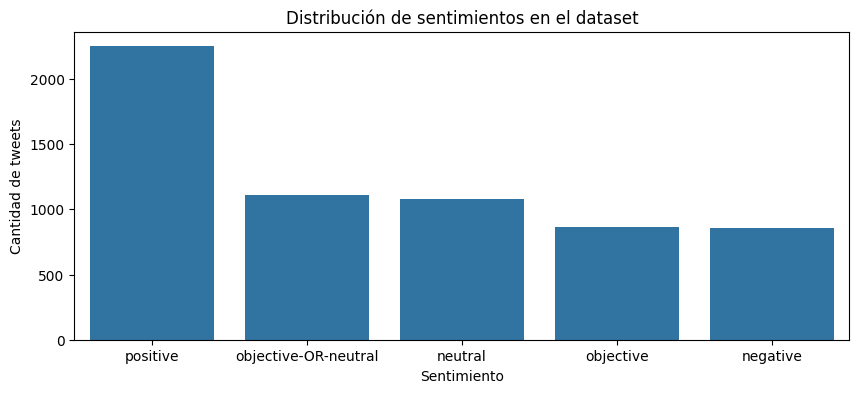

In [5]:
# Conteo de etiquetas
sentiment_counts = df_train['sentiment'].value_counts()

# Mostrar conteo
print(sentiment_counts)

# Gráfica
plt.figure(figsize=(10,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Distribución de sentimientos en el dataset")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de tweets")
plt.show()

In [6]:
for label in df_train['sentiment'].unique():
    print(f"\n -- Ejemplos de tweets con sentimiento '{label}':\n")
    sample = df_train[df_train['sentiment'] == label]['text'].sample(3, random_state=1)
    for i, t in enumerate(sample):
        print(f"{i+1}. {t}")


 -- Ejemplos de tweets con sentimiento 'positive':

1. Congrats to Ryder Cup Captain @Love3d for his 6 under 64 in Thursday's opening round of the Honda Classic. Keep it going!
2. Looking forward to Celebrity Juice tonight.
3. Shocking! Warriors may actually have the best coaching staff in the Pacific Division. #GSW #NBA #Lakers #Clippers #Suns #Kings

 -- Ejemplos de tweets con sentimiento 'negative':

1. I lost respect for #AnnaHazare the minute he sat at "Duratma" Gandhi's graveyard yesterday. India does not need another Gandhi. Vandemataram
2. Protest against the Mitch Daniels Purdue Presidential nomination tomorrow @ Loeb Theater 2:30 pm. Bring a friend! #SOAPurdue
3. DTN USA: Charlie Sheen's 'winning' ways get roasted: He may have looked like he was "winning," but actor C... http://on.today.com/qkNiZW 

 -- Ejemplos de tweets con sentimiento 'neutral':

1. About to begin our sojourn on "Mysterious Island" for VBS. Plane crash, storm, chased by pirates...and that's just 1st night

Distribución en entrenamiento:
 sentiment
neutral     3057
positive    2249
negative     859
Name: count, dtype: int64

Distribución en prueba:
 sentiment
neutral     437
positive    358
negative    179
Name: count, dtype: int64


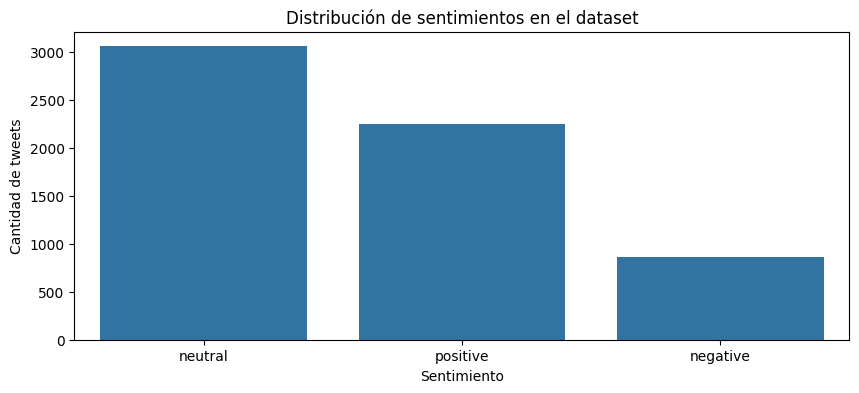

In [7]:
# Función para reducir las clases
def reduce_classes(sentiment):
    if sentiment.lower() == 'positive':
        return 'positive'
    elif sentiment.lower() == 'negative':
        return 'negative'
    else:
        return 'neutral'  # incluye 'neutral', 'objective', 'objective-OR-neutral'

#  Aplicar reducción de clases 
df_train['sentiment'] = df_train['sentiment'].apply(reduce_classes)
df_test['sentiment']  = df_test['sentiment'].apply(reduce_classes)

#  Mostrar distribución de clases después de la reducción 
print("Distribución en entrenamiento:\n", df_train['sentiment'].value_counts())
print("\nDistribución en prueba:\n", df_test['sentiment'].value_counts())

# Conteo de etiquetas
sentiment_counts = df_train['sentiment'].value_counts()

# Gráfica
plt.figure(figsize=(10,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Distribución de sentimientos en el dataset")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de tweets")
plt.show()

# Diseño del pipeline de preprocesamiento

Para maximizar la calidad del vocabulario y la capacidad de los modelos de aprendizaje supervisado para capturar sentimientos en tweets, se implementó un pipeline de preprocesamiento de texto que combina limpieza, normalización y enriquecimiento semántico. Este proceso se desarrolla como una secuencia de pasos interdependientes, cada uno con un propósito específico:

1. **Obtención de datos**

El primer paso consiste en la lectura del conjunto de datos de tweets. En esta etapa se verifica la estructura del archivo y se cargan las columnas de interés (identificador, autor, etiqueta de sentimiento y texto). La lectura inicial se realiza sin aplicar transformaciones para conservar la información original, lo que permite una detección precisa de la codificación en el paso siguiente.

2. **Detección de la codificación del texto**

Antes de procesar el texto, se realiza una detección automática de la codificación utilizando bibliotecas como chardet. Este paso es crucial para evitar errores de decodificación y pérdida de información.
En la mayoría de los casos, la codificación UTF-8 resulta la más adecuada, ya que soporta caracteres especiales, emojis y símbolos multilingües comunes en redes sociales, garantizando una interpretación fiel del contenido. Sin embargo, este análisis permite justificar técnicamente la elección del formato.

3. **Tokenización por sentencia**

El texto se divide inicialmente en oraciones mediante tokenización por sentencia. Esta segmentación permite tratar cada idea o emoción de manera independiente. La justificación principal es que los tweets pueden contener varias ideas o sentimientos en un solo mensaje, y analizar oraciones individualmente ayuda a preservar relaciones contextuales y a capturar correctamente emociones parciales dentro del texto.

4. **Tokenización por palabras**

Cada oración se fragmenta en tokens individuales usando un tokenizador especializado en tweets. Esta etapa es esencial porque los modelos de PLN trabajan sobre unidades discretas de texto. Además, los tokenizadores de tweets manejan adecuadamente abreviaciones, signos de repetición (ej. “soooo happy”) y símbolos especiales propios de redes sociales, garantizando que la representación del texto sea precisa y completa.

5. **Detección y etiquetado de patrones estructurados**

Se identifican y etiquetan elementos como URLs, hashtags, menciones y emoticones mediante expresiones regulares. La justificación es que estos elementos son altamente frecuentes en tweets y no siempre aportan valor semántico directo. Reemplazarlos por identificadores simbólicos evita que el modelo interprete estas secuencias como palabras comunes, reduciendo ruido y preservando la información de forma estructurada.

6. **Restauración y transformación de hashtags y menciones**

Las menciones y hashtags se restauran como tokens etiquetados, manteniendo su posición y presencia en el texto. Esto permite al modelo capturar información contextual y social relevante, como referencias a personas o temas, que pueden influir en la interpretación emocional de los mensajes.

7. **Mapeo de emoticones a tokens de sentimiento**

Los emoticones, que son símbolos visuales de emociones, se transforman en tokens que representan su carga afectiva (por ejemplo, :) → “joy”). Este paso es crucial porque los emoticones contienen información emocional explícita que, de no mapearse, se perdería al tratar el texto de forma estrictamente léxica, reduciendo la capacidad del modelo de detectar sentimientos positivos, negativos o neutros.

8. **Limpieza de tokens**

Se eliminan signos de puntuación y caracteres irrelevantes, y se aplica lowercasing. La justificación es que esto reduce la dimensionalidad del vocabulario y evita que el modelo considere variantes ortográficas o de capitalización como palabras diferentes. Por ejemplo, “Happy” y “happy” se consideran la misma palabra, lo que mejora la generalización.

9. **Eliminación de stopwords**

Palabras vacías, como artículos y preposiciones, se eliminan de manera selectiva según el idioma detectado. Esto permite que el modelo se concentre en tokens significativos y con carga semántica, sin perder palabras que puedan portar información emocional, lo que es especialmente importante en análisis de sentimientos donde términos como “no” o “very” pueden modificar la polaridad.

10. **Etiquetado morfosintáctico (PoS Tagging)**

Cada token se analiza gramaticalmente para asignarle su categoría (sustantivo, verbo, adjetivo, etc.). Esto justifica su inclusión porque permite diferenciar palabras según su función y contexto, facilitando la lematización precisa y ayudando a capturar patrones lingüísticos que caracterizan emociones específicas, como adjetivos positivos o negativos.

11. **Lematización**

Cada palabra se transforma a su forma base o lema. Esto reduce la redundancia léxica y permite que el modelo generalice correctamente sobre distintas conjugaciones o formas derivadas. Por ejemplo, “running” y “ran” se mapean a “run”, evitando dispersión en la representación y mejorando la capacidad de detección de sentimientos asociados a conceptos clave.

12. **Expansión semántica con taxonomías léxicas**

Se enriquece el vocabulario usando recursos como SentiWordNet, incorporando anotaciones de sentimiento. La justificación es que esto amplía la cobertura semántica y ayuda al modelo a capturar matices afectivos implícitos, lo que es fundamental para manejar la variabilidad y ambigüedad del lenguaje en tweets.

13. **Integración de tokens procesados**

Finalmente, todos los tokens limpios, lematizados y enriquecidos se consolidan en un corpus listo para representar mediante vectores y entrenar modelos de clasificación. Este paso asegura que el pipeline produzca un conjunto de datos homogéneo, consistente y optimizado para la captura de patrones semánticos y emocionales.

<br>

Este pipeline se justifica por su equilibrio entre limpieza y preservación de información semántica. A diferencia de enfoques más agresivos, mantiene elementos expresivos como emojis y hashtags, preserva estructuras gramaticales mediante PoS Tagging y enriquece el texto con taxonomías léxicas. Esto permite que los modelos de PLN no solo trabajen con texto limpio, sino que capturen fielmente las emociones implícitas y explícitas presentes en los tweets, mejorando su capacidad predictiva para todas las clases de sentimiento, especialmente las minoritarias.

# Análisis del vocabulario y visualizaciones

Para comprender mejor la estructura y características del corpus de tweets, se realizaron diversas visualizaciones enfocadas en la distribución del vocabulario, la riqueza léxica y la presencia de elementos expresivos como hashtags y emojis. Cada visualización tiene un propósito específico y permite justificar decisiones en el procesamiento de texto y la construcción de modelos de PLN.

In [239]:
# Limpieza rápida 
df_train["clean_text"] = df_train["text"].astype(str).str.lower()

# Tokenización sencilla
df_train["tokens"] = df_train["clean_text"].apply(nltk.word_tokenize)
df_train["num_tokens"] = df_train["tokens"].apply(len)

## Distribución de longitudes de tweets

Se graficó la distribución del número de palabras por tweet para evaluar la variabilidad en la longitud de los textos. Tweets muy cortos pueden carecer de contexto suficiente para clasificar sentimientos, mientras que tweets más largos podrían contener múltiples ideas o emociones. Conocer esta distribución permite ajustar parámetros de modelos que dependan de la longitud de secuencia, como embeddings o redes neuronales recurrentes.

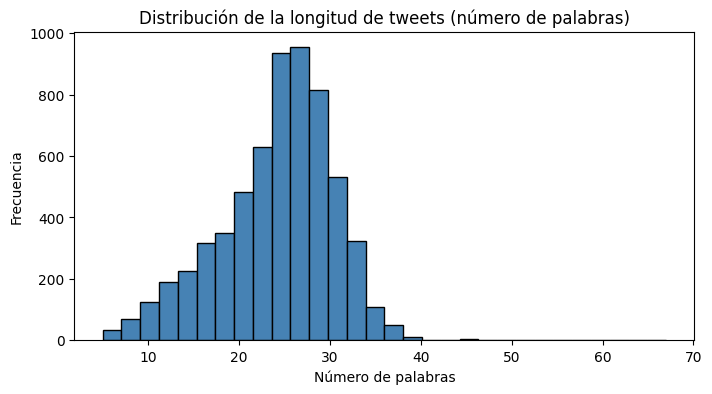

In [240]:
plt.figure(figsize=(8,4))
plt.hist(df_train["num_tokens"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribución de la longitud de tweets (número de palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

## Frecuencia de palabras (Top-N más comunes)

El conteo de las palabras más frecuentes permite identificar términos muy comunes en el corpus, incluyendo stopwords, nombres propios, emoticones o abreviaciones. Esta visualización ayuda a decidir qué palabras podrían eliminarse o mantenerse durante la limpieza y normalización, así como a detectar sesgos en el vocabulario que podrían afectar la clasificación.

/tmp/ipykernel_5109/1415581207.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Palabra", x="Frecuencia", data=top_words, palette="viridis")


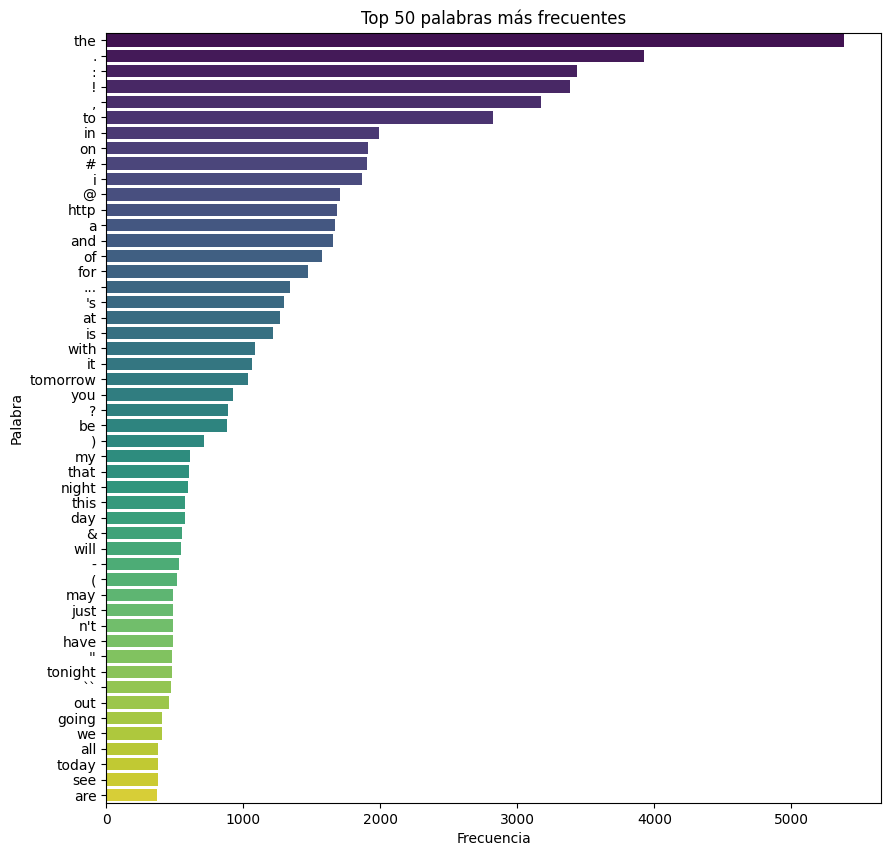

In [241]:
all_tokens = [token for tokens in df_train["tokens"] for token in tokens]
word_freq = Counter(all_tokens)

top_words = pd.DataFrame(word_freq.most_common(50), columns=["Palabra", "Frecuencia"])
plt.figure(figsize=(10,10))
sns.barplot(y="Palabra", x="Frecuencia", data=top_words, palette="viridis")
plt.title("Top 50 palabras más frecuentes")
plt.show()


## Nube de palabras (WordCloud)

La nube de palabras proporciona una representación visual intuitiva del peso relativo de cada término en el corpus. Es útil para identificar rápidamente palabras que dominan el vocabulario y verificar si palabras relevantes para la expresión de sentimientos aparecen de forma destacada.

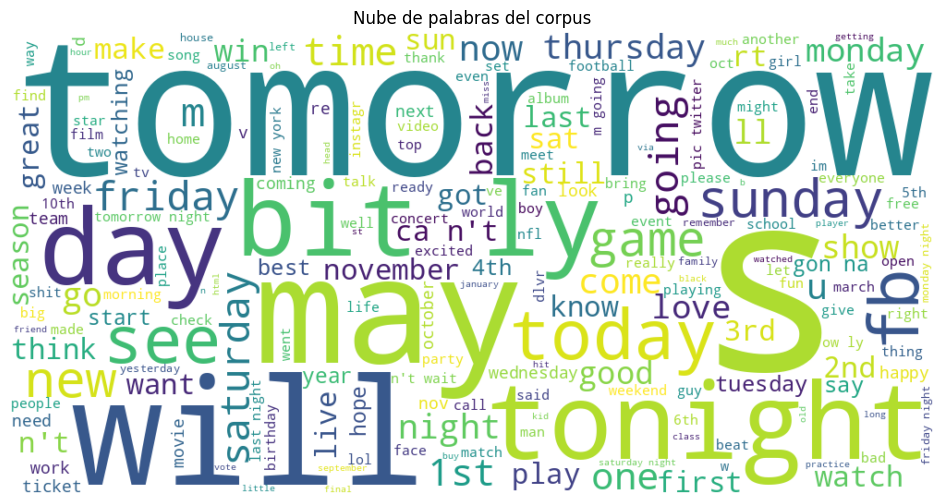

In [242]:
text_str = " ".join(all_tokens)
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text_str)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras del corpus")
plt.show()

## Comparativa de frecuencia por sentimiento

Comparar las palabras más frecuentes dentro de cada clase de sentimiento permite observar patrones léxicos distintivos. Por ejemplo, ciertas palabras o hashtags pueden estar fuertemente asociadas a emociones positivas o negativas. Esto justifica la preservación de hashtags y emoticones en el pipeline, ya que aportan información emocional explícita. En este caso se puede apreciar que las más frecuentes son stopwords, lo que indica una posible limpieza al respecto.

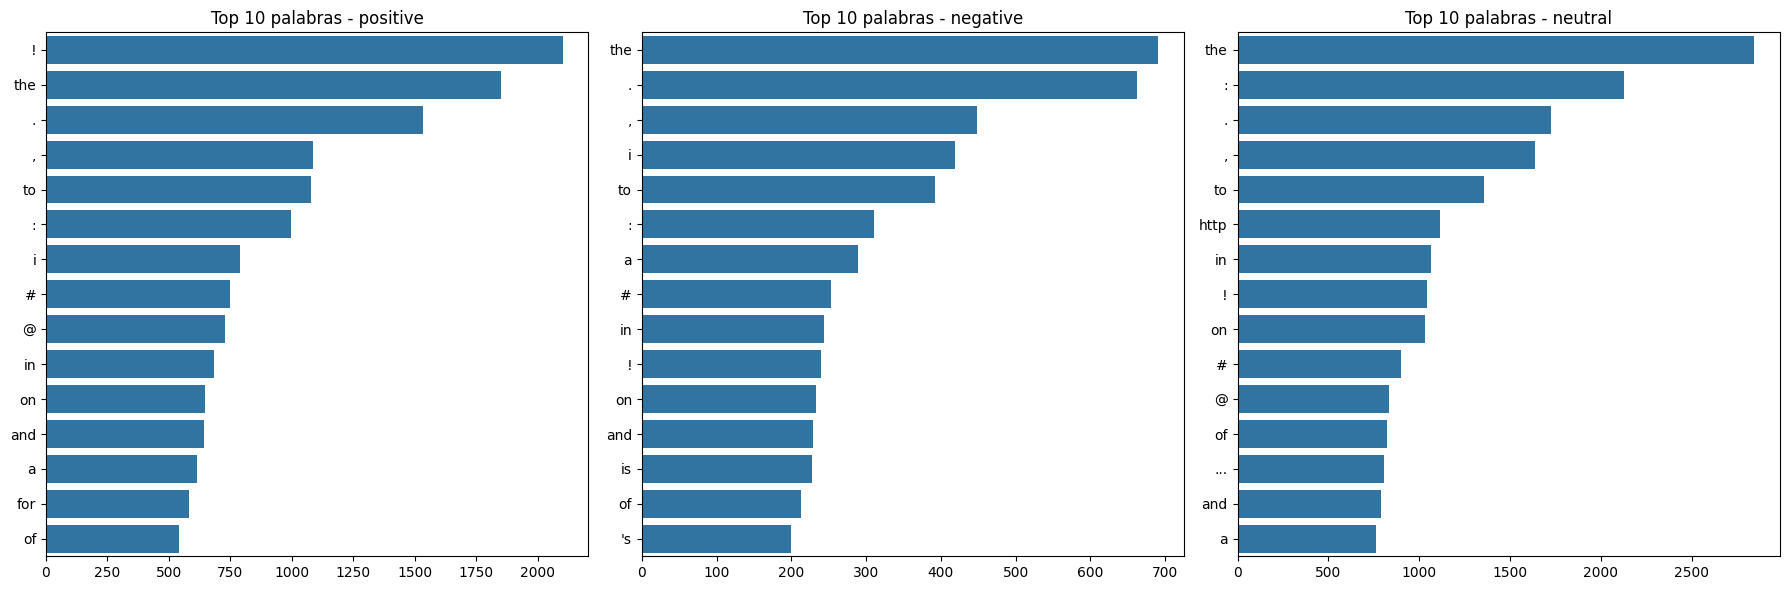

In [243]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sentiments = df_train["sentiment"].unique()

for i, s in enumerate(sentiments):
    tokens_s = [t for tokens in df_train[df_train["sentiment"] == s]["tokens"] for t in tokens]
    freq_s = Counter(tokens_s).most_common(15)
    sns.barplot(y=[w for w, _ in freq_s], x=[f for _, f in freq_s], ax=axes[i])
    axes[i].set_title(f"Top 10 palabras - {s}")

plt.tight_layout()
plt.show()


## Distribución de frecuencias según la Ley de Zipf

La representación de la frecuencia de palabras frente a su rango permite verificar que el corpus sigue la Ley de Zipf, característica típica de textos naturales. Esta propiedad es importante para entender la dispersión del vocabulario y para tomar decisiones sobre técnicas de representación como Bag of Words o TF-IDF.

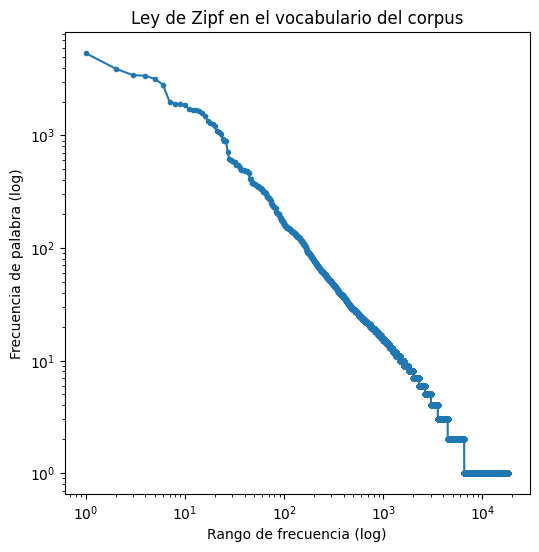

In [244]:
freqs = np.array(sorted(word_freq.values(), reverse=True))
ranks = np.arange(1, len(freqs) + 1)
plt.figure(figsize=(6,6))
plt.loglog(ranks, freqs, marker=".")
plt.title("Ley de Zipf en el vocabulario del corpus")
plt.xlabel("Rango de frecuencia (log)")
plt.ylabel("Frecuencia de palabra (log)")
plt.show()

## Diversidad léxica (Lexical Richness)

La relación entre palabras únicas y palabras totales por tweet permite medir la riqueza léxica del corpus. Tweets con mayor diversidad léxica aportan más información semántica, mientras que tweets repetitivos podrían limitar la capacidad del modelo de generalizar. Esto respalda decisiones sobre lematización y expansión semántica en el pipeline.

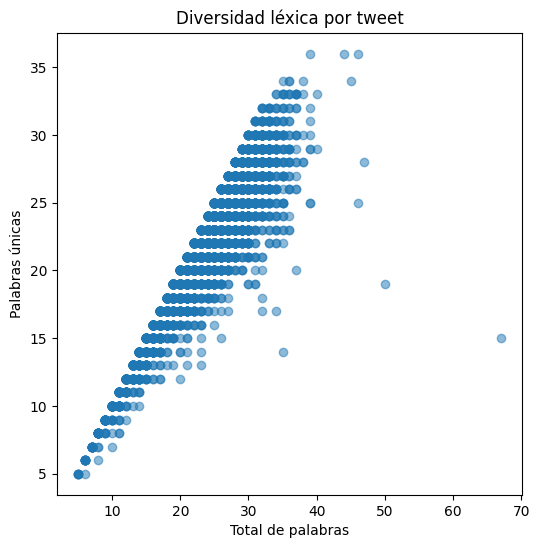

In [245]:
df_train["unique_tokens"] = df_train["tokens"].apply(lambda x: len(set(x)))
plt.figure(figsize=(6,6))
plt.scatter(df_train["num_tokens"], df_train["unique_tokens"], alpha=0.5)
plt.title("Diversidad léxica por tweet")
plt.xlabel("Total de palabras")
plt.ylabel("Palabras únicas")
plt.show()


## Distribución de PoS Tags (etiquetas gramaticales)

La visualización de las etiquetas gramaticales permite analizar la composición lingüística de los tweets. Un predominio de adjetivos y adverbios podría indicar alta carga emocional, mientras que sustantivos y nombres propios reflejan temas o entidades mencionadas. Esto respalda el uso de PoS tagging en el pipeline para mejorar la lematización y la captura de patrones sintácticos relacionados con sentimientos.

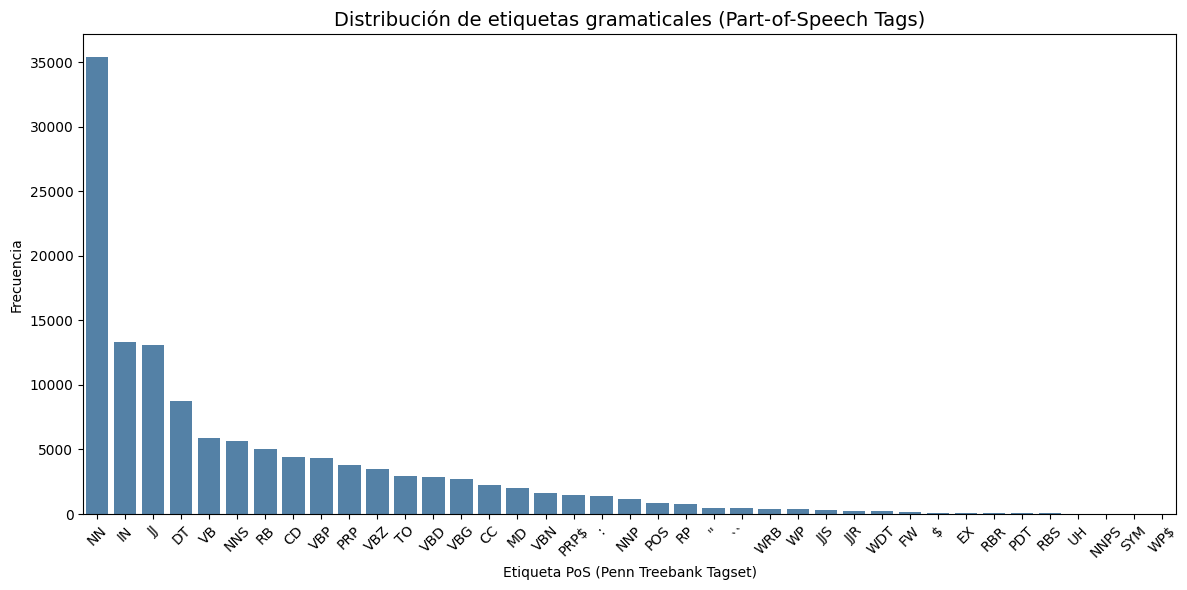

In [246]:
sample_texts = df_train["clean_text"]

# Une el texto de ejemplo en una sola cadena
sampleString = " ".join(sample_texts)

# Carga el analizador léxico de oraciones para el idioma inglés.
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

# Tokenizar en oraciones (utilizando el modelo específico del inglés)
sentenceTokens = tokenizer.tokenize(sampleString)

# Tokenizar a nivel de palabras
wordTokens = word_tokenize(sampleString)

#  Eliminar la puntuación de las palabras.
cleanedTokens = [word for word in wordTokens if word not in string.punctuation]

# Aplicar el etiquetado POS a las fichas de palabras
posTags = pos_tag(cleanedTokens, lang='eng')

# Obtener unicamente los tags para obtener el histograma de frecuencias
tags = [item[1] for item in posTags]

# Contar frecuencia de cada etiqueta PoS
pos_counts = Counter(tags)
pos_df = pd.DataFrame(pos_counts.items(), columns=["Etiqueta", "Frecuencia"]).sort_values(by="Frecuencia", ascending=False)

# Graficar
plt.figure(figsize=(12,6))
sns.barplot(data=pos_df, x="Etiqueta", y="Frecuencia", color="steelblue")
plt.title("Distribución de etiquetas gramaticales (Part-of-Speech Tags)", fontsize=14)
plt.xlabel("Etiqueta PoS (Penn Treebank Tagset)")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Matriz de coocurrencia de palabras

La matriz de coocurrencia muestra cómo las palabras más frecuentes aparecen juntas en los tweets. Es útil para detectar relaciones semánticas y asociaciones de términos que podrían reflejar emociones compartidas o contextos similares, y justifica técnicas de bigramas/trigramas o embeddings de palabras.

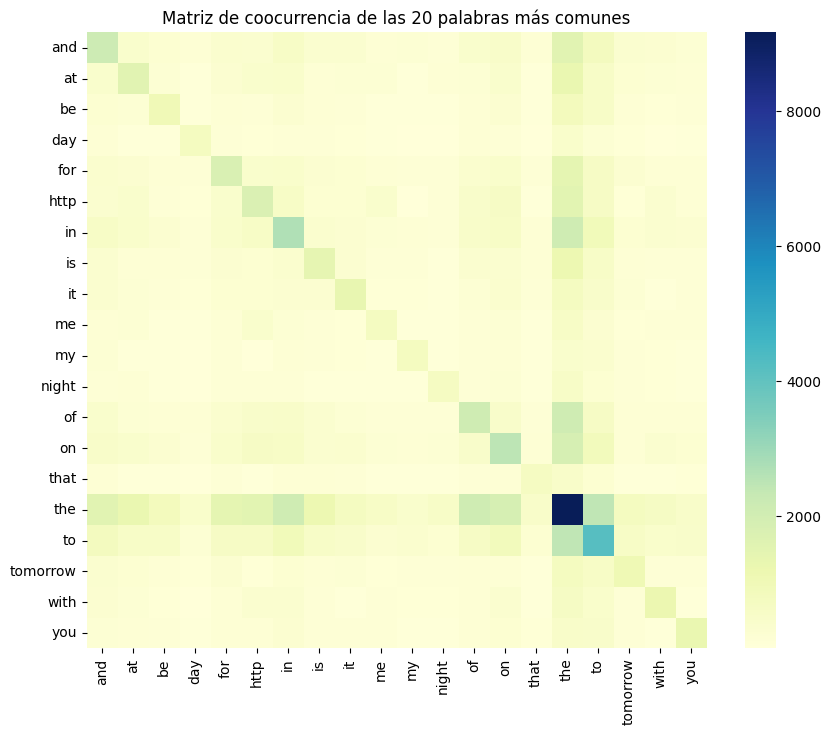

In [16]:
vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(df_train["clean_text"])
cooc_matrix = (X.T @ X).toarray()
words = vectorizer.get_feature_names_out()

plt.figure(figsize=(10,8))
sns.heatmap(cooc_matrix, xticklabels=words, yticklabels=words, cmap="YlGnBu")
plt.title("Matriz de coocurrencia de las 20 palabras más comunes")
plt.show()


## Análisis de bigramas y trigramas más comunes

Identificar secuencias de dos o tres palabras más frecuentes permite captar expresiones compuestas que transmiten significados específicos, relevantes para la polaridad de los tweets.

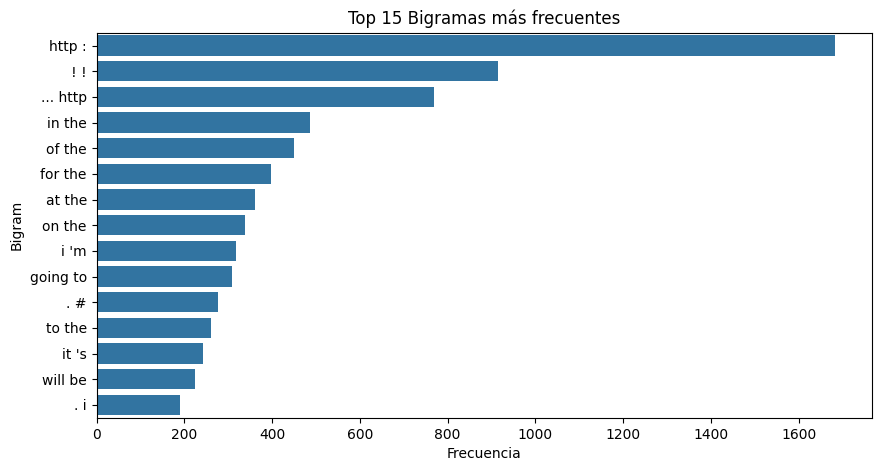

In [17]:
def get_ngrams(tokens_list, n=2, top=15):
    all_ngrams = [ng for tokens in tokens_list for ng in ngrams(tokens, n)]
    return Counter(all_ngrams).most_common(top)

bigrams = get_ngrams(df_train["tokens"], n=2)
bigrams_df = pd.DataFrame(bigrams, columns=["Bigram", "Frecuencia"])
bigrams_df["Bigram"] = bigrams_df["Bigram"].apply(lambda x: " ".join(x))

plt.figure(figsize=(10,5))
sns.barplot(y="Bigram", x="Frecuencia", data=bigrams_df)
plt.title("Top 15 Bigramas más frecuentes")
plt.show()


## Análisis de polaridad en hashtags

La visualización de hashtags más comunes por sentimiento muestra cómo los usuarios etiquetan emociones de forma explícita, reforzando la decisión de preservar hashtags en el pipeline para capturar información de polaridad.

<Figure size 1000x600 with 0 Axes>

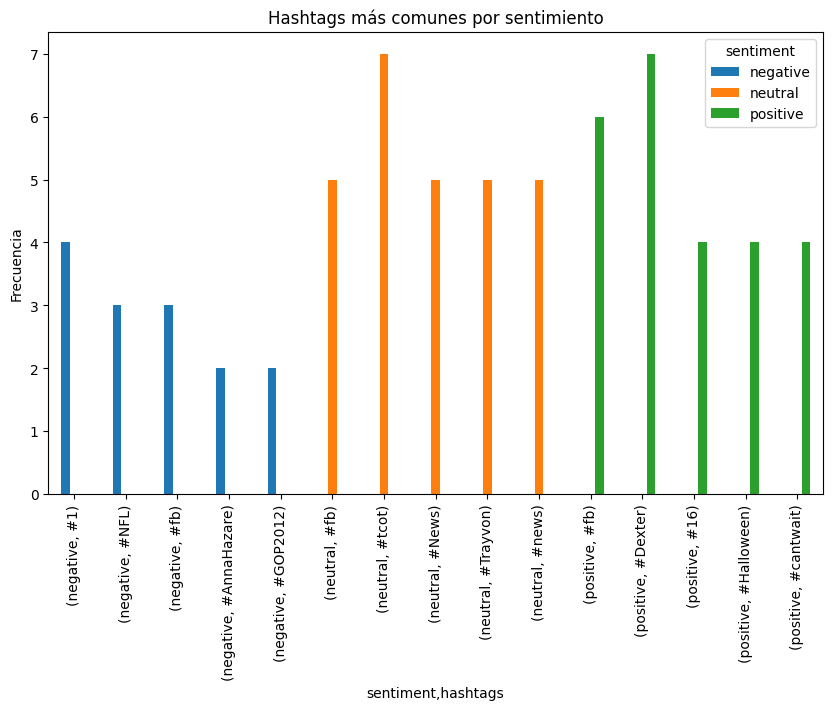

In [18]:
# Simple extracción de emojis/hashtags para ejemplo
df_train["hashtags"] = df_train["text"].apply(lambda x: re.findall(r"#\w+", x))

hashtags_exp = df_train.explode("hashtags")
hashtag_counts = hashtags_exp.groupby("sentiment")["hashtags"].value_counts().groupby(level=0).nlargest(5)

plt.figure(figsize=(10,6))
hashtag_counts.unstack(level=0).plot(kind="bar", figsize=(10,6))
plt.title("Hashtags más comunes por sentimiento")
plt.ylabel("Frecuencia")
plt.show()

## Existencia de emojis en el texto

La detección de tweets con emojis permite evaluar la relevancia de estos elementos en la expresión emocional. Su alta frecuencia justifica el mapeo de emojis a tokens de sentimiento en el pipeline, asegurando que el modelo capture señales afectivas explícitas que no se transmiten solo con palabras. En este caso se puede apreciar que no hay emojis como tal, si no que más adelante se visualizarabn emoticones como :) o XD.

In [19]:
# Regex para emojis 
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticones
    u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
    u"\U0001F680-\U0001F6FF"  # transporte y mapas
    u"\U0001F1E0-\U0001F1FF"  # banderas
    u"\U00002700-\U000027BF"  # dingbats
    u"\U0001F900-\U0001F9FF"  # símbolos suplementarios
    u"\U00002600-\U000026FF"  # otros símbolos
    "]+", flags=re.UNICODE)

# Verificar cuántos textos contienen al menos un emoji
emoji_count = sum(df_train["clean_text"].apply(lambda x: bool(emoji_pattern.search(x))))
print(f"Tweets con al menos un emoji: {emoji_count}")

Tweets con al menos un emoji: 0


## Detección del lenguaje en el Corpus

En esta visualización se analiza la distribución de idiomas presentes en el corpus de tweets mediante la detección automática de idioma aplicada a cada mensaje. Los resultados muestran una clara predominancia del inglés, con 6,131 tweets identificados como tal, lo que representa prácticamente la totalidad del dataset. Los demás idiomas, incluyendo tagalo (tl), afrikáans (af), indonesio (id), español (es), y varios idiomas europeos y africanos en cantidades mínimas, aparecen de manera marginal. Por esto mismo no se considerará en el pipeline una detección dinámimca de lenguaje ya que lo más probable es que palabras del vocabulario que pertenezcan a otro idioma no tendrán una frecuencia significativa en la totalidad del conjunto de datos, por lo que no generará relevancia.

/tmp/ipykernel_5109/2811538241.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lang_counts.index, y=lang_counts.values, palette="viridis")


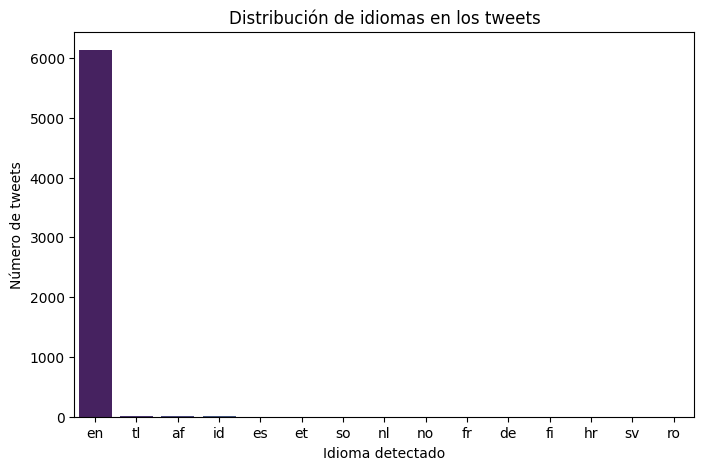

In [248]:
# Función para detectar idioma
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

# Detectar idioma para cada tweet
df_train["language"] = df_train["text"].astype(str).apply(detect_language)

# Contar frecuencia de cada idioma
lang_counts = df_train["language"].value_counts()

# Graficar distribución de idiomas (barras)
plt.figure(figsize=(8,5))
sns.barplot(x=lang_counts.index, y=lang_counts.values, palette="viridis")
plt.title("Distribución de idiomas en los tweets")
plt.xlabel("Idioma detectado")
plt.ylabel("Número de tweets")
plt.show()

# Implementación del pipeline
Es justo mencionar que los pasos uno y dos sobre la obtención de los datos y su lectura de acuerdo con la codificación adecuada se realizarón en secciones previas, por lo que en este apartado se continuará con la imlementación formal del preprocesamiento propuesto en el pipeline para los textos.

Se utilizará una pequeña muestra del conjunto de datos de entrenamiento para demostrar las transformaciones efectuadas por cada paso del pipeline.

In [20]:
def showText(text_vector):
    for i in range(len(text_vector)):
        print(i, text_vector[i])

train_text = df_train["text"]
showText(train_text)

0 Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
1 Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)
2 with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.
3 Talking about ACT's && SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.
4 They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll
5 Im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched
6 Apple software, retail chiefs out in overhaul: SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads... http://bit.ly/XQEhJU 
7 #Livewire Nadal confirmed for Mexican Open in February: Rafael Nadal is set to play at the Me... http://bit.ly/WY4Vjy  #LiveWireAthletics
8 #Iran US delisting MKO from

## Tokenización a nivel de sentencia

In [22]:
# Descargar los recursos del tokenizador
nltk.download("punkt")

# Descargar el tokenizador para ingles
TOKENIZER = nltk.data.load("tokenizers/punkt/english.pickle")

def sentence_tokenize(text):
    global TOKENIZER
    
    return TOKENIZER.tokenize(text)

[nltk_data] Downloading package punkt to /home/mapa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Implementación Limpieza con Regex (URLs, Menciones de usuario y hastags)

In [ ]:
# Patron Regex para URLs
urlPattern = r"https?://[^\s]+(?<![.,;!?])"

# Patron Regex para Hashtags
hashtagPattern = r"#\w+"

# Patron Regex para Menciones
mentionPattern = r"@\w+"

# Patrón regex para emoticones comunes con delimitadores
emoticonPattern = r"""
(?:
    (?<=\s)|(?<=^)|(?<=[.,!?])     # lookbehind: debe estar al inicio, después de espacio o puntuación
)
(
    [<>]?
    [:;=8xX]                       # ojos
    [\-o\*\']?                     # nariz (opcional)
    [\)\]\(\[dDpP/:\}\{@\|3]       # boca
    |
    [\)\]\(\[dDpP/:\}\{@\|3]       # boca primero
    [\-o\*\']?                     # nariz opcional
    [:;=8xX]                       # ojos
    [<>]?
    |
    <3+                            # corazones
    |
    [xX]+[dD]+                     # XD, xD, XDD
    |
    [;:][']\(+                     # caritas llorando tipo :'( 
    |
    [;:][pP]+                      # lenguas tipo :P, :p
    |
    [()]{2,}                       # repeticiones como (((
)
(?=\s|$|[.,!?])                    # lookahead: seguido de espacio, puntuación o fin
"""

# Función de búsqueda segura 
def findWithRegex(pattern, tag, text, flags=0):
    """
    Busca coincidencias con un patrón regex, las reemplaza con una etiqueta temporal
    (p. ej., 'emoticon_0', 'emoticon_1', ...), y devuelve la lista de coincidencias originales
    junto con el texto modificado.
    """
    # Usar re.finditer para tener control sobre los reemplazos exactos
    matches = list(re.finditer(pattern, text, flags))
    originals = []
    new_text = text
    offset = 0

    for i, m in enumerate(matches):
        match_text = m.group(1) if m.lastindex else m.group(0)
        originals.append(match_text)

        # Calcular índices ajustados
        start, end = m.start(), m.end()
        start += offset
        end += offset

        # Reemplazar con etiqueta
        replacement = f"{tag}{i}"
        new_text = new_text[:start] + replacement + new_text[end:]
        offset += len(replacement) - (end - start)

    return originals, new_text


# Restaurar etiquetas 
def restoreTags(tags, tag, text):
    """
    Restaura hashtags y menciones eliminando el @ y # originales,
    o cualquier otro tipo de tag reemplazado.
    """
    for i, original in enumerate(tags):
        text = [original[1:].lower() if token == f"<{tag}{i}>" else token for token in text]
    return text


# Eliminar etiquetas 
def deleteTag(tag, text):
    """
    Elimina todos los tokens que comienzan con la etiqueta dada.
    Ejemplo: deleteTag("<url_", tokens) eliminará tokens como '<url_0>', '<url_1>', etc.
    """
    return [token for token in text if not token.startswith(tag)]


## Transformación de Emoticones

In [24]:
# Diccionario de emoticones por sentimiento 
emoticon_sentiment_map = {
    "<joy>": {
        ":)", ":-)", "=)", ":D", ":-D", "=D", "XD", "xD", "X-D", "XP", "xP", "X)", "x)", ";D",
        "8)", "8-3", "8P", "8p", "83", "=3", "3:)", "3:-)", "(:", "(;", ";-)", ";)", "p;", "P;",
        ":o)", "d:", "D:", "dx", "DX", "x3", "X3"
    },
    "<sadness>": {
        ":(", ":-(", ":'(", ")':", "):", "D:", "d':", "(((", "(((((", "((", ")))", "))))"
    },
    "<love>": {
        "<3", "<33", "<333", "<3333", "<33333"
    },
    "<anger>": {
        ">:(", ">=(", ">=)", "=/", ">:O", ">:o"
    },
    "<surprise>": {
        ":o", ":O", ":-o", ":-O"
    },
    "<neutral>": {
        ":|", "=/", "=|"
    },
    "<disgust>": {
        ":/", "=/", "8/", "/8", "P:", "p:", "do:", "doX", "/x", "x:", "X:"
    }
}

# Normalización de emoticones 
def normalize_emoticon(token):
    token = token.strip()
    token = token.lower()
    token = token.replace('—', '-')
    token = re.sub(r'([()<>/8xp;:=DdoO-])\1{1,}', r'\1', token)
    return token

# Diccionario rápido: emoticon → sentimiento
emoticon_to_sentiment = {}
for label, emotset in emoticon_sentiment_map.items():
    for emo in emotset:
        norm = normalize_emoticon(emo)
        emoticon_to_sentiment[norm] = label

# Función para mapear token a sentimiento
def map_emoticon_to_sentiment_token(token, emoticons_list=None):
    """
    Mapea:
      - placeholders tipo 'emoticon_3' → obtiene el emoticon real de la lista 'emoticons_list'
      - emoticon textual (':)') → usa el diccionario global
      - otro token → se deja igual
    """
    m = re.match(r"<?emoticon_(\d+)>?$", token)
    if m and emoticons_list is not None:
        idx = int(m.group(1))
        if 0 <= idx < len(emoticons_list):
            emo_real = emoticons_list[idx]
            norm = normalize_emoticon(emo_real)
            return emoticon_to_sentiment.get(norm, emo_real)

    norm = normalize_emoticon(token)
    return emoticon_to_sentiment.get(norm, token)

## Transformación a Minusculas

In [25]:
# Lowercase
def to_lowercase(text):
    return text.lower()

## Eliminación de Stopwords

In [26]:
# Configurar stopwords personalizadas
stop_words = set(stopwords.words('english'))
keep_words = {"not", "no", "nor", "but", "very", "so", "too", "never", "really", "n't"}
custom_stopwords = stop_words - keep_words

def delete_stopword(token):
    # Quitar tokens vacíos o stopwords neutrales
    if not token or token in custom_stopwords:
        return None
    return token

## Eliminación de Signos de Puntuación

In [ ]:
# Eliminación de signos de puntuación
def remove_punctuation(token):
    # mantener contracciones tipo isn't / don't / i'm
    if re.match(r"[a-zA-Z]+('[a-zA-Z]+)?$", token):
        return token
    
    # agregar puntuaciones extras manuales (unicode)
    extra_punct = "…“”‘’—–•"  
    
    # puntuación ascii 
    token = token.translate(str.maketrans("", "", string.punctuation + extra_punct))
    
    return token

## Agrupación de Limpieza para Tokens

In [28]:
def cleanToken(token, placeholders):
    # No limpiar placeholders
    if any(token.startswith(pref) for pref in placeholders):
        return token

    # Lowercase
    token = to_lowercase(token)

    # Mantener contracciones (isn't, don't, i'm) y eliminar signos de putuación
    token = remove_punctuation(token)

    # Quitar tokens vacíos o stopwords neutrales
    token = delete_stopword(token)

    return token

## Etiquetado Part of Speech

In [29]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Etiquetado PoS
def wordnetPoS(word):
    # Obtener POS tag
    pos_tag = nltk.pos_tag([word])[0][1]

    # Clasificar segun la etiqueta
    if pos_tag.startswith('J'):
    # Adjective
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
    # Noun
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
    # Verb
        return wordnet.VERB
    elif pos_tag.startswith('R'):
    # Adverb
        return wordnet.ADV
    else:
    # Predeterminado
        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/mapa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/mapa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Lematización

In [30]:
# Lematización
lemmatizer = WordNetLemmatizer()

def lemmatize(word, pos_function):
    return lemmatizer.lemmatize(word, pos_function(word))

## Expansión Semántica

In [31]:
nltk.download('sentiwordnet')

def enrich_with_sentiwordnet(token, pos):
    # pos debe ser 'n','v','a','r'
    synsets = list(swn.senti_synsets(token, pos))
    if len(synsets) == 0:
        return None
    
    # promedio del score de todos los senses
    avg_pos = sum([s.pos_score() for s in synsets]) / len(synsets)
    avg_neg = sum([s.neg_score() for s in synsets]) / len(synsets)
    
    if avg_pos > avg_neg:
        return "SENT_POS"
    elif avg_neg > avg_pos:
        return "SENT_NEG"
    else:
        return None

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/mapa/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


## Agrupación del Pipeline Completo

In [32]:
total_Emoticons = []

def preProcess(text):
    # Iniciar tokenizador de tweets para palabras
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
    
    # ====== Tokenizar por sentencia
    sentences = sentence_tokenize(text)

    textWords = []

    emoticons_local = []
    
    for sentence in sentences:
        
        # ====== Aplicar Regex para etiquetar elementos 
        # Etiquetar URLs
        urls, sentence = findWithRegex(urlPattern, "url_", sentence)
        
        # Etiquetar Hashtags
        hashtags, sentence = findWithRegex(hashtagPattern, "hashtag_", sentence)

        # Etiquetar Menciones
        mentions, sentence = findWithRegex(mentionPattern, "mention_", sentence)

        # Etiquetar Emoticones
        emoticons, sentence = findWithRegex(emoticonPattern, "emoticon_", sentence, flags=re.VERBOSE)

        # Antes de tokenizar
        sentence = re.sub(r"(url_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(hashtag_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(mention_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(emoticon_\d+)", r"<\1>", sentence)

        # ====== Tokenización por palabra
        sentenceWords = tweet_tokenizer.tokenize(sentence)
        
        # ====== Eliminación de signos de puntuación y aplicar minusculas
        placeholders = ["<url_", "<hashtag_", "<mention_", "<emoticon_"]

        # ====== Aplicar limpieza a los tokens (Aplicar lowercase, eliminación de signos de puntuación y stopwords)
        sentenceWords = [ cleanToken(token, placeholders) for token in sentenceWords if cleanToken(token, placeholders) is not None ]

        # Eliminación de URLs
        sentenceWords = deleteTag("<url_", sentenceWords)

        # Restaurar etiquetas
        sentenceWords = restoreTags(hashtags, "hashtag_", sentenceWords)
        sentenceWords = restoreTags(mentions, "mention_", sentenceWords)

        # ====== Mapear emoticones a sentimientos
        sentenceWords = [map_emoticon_to_sentiment_token(token, emoticons) if token.startswith("<emoticon_") else token for token in sentenceWords]
        
        # Limpiar '<>'
        sentenceWords = [token.strip("<>") for token in sentenceWords]

        # Aplicar PoS y Lematización
        sentenceWords = [ lemmatize(word, wordnetPoS) for word in sentenceWords ]

        # Enriquecer el vocabulario con sentiwordnet
        enriched = []
        for w in sentenceWords:
            p = wordnetPoS(w) 
            senti = enrich_with_sentiwordnet(w, p)
            if senti:
                enriched.append(senti)
            enriched.append(w)
        sentenceWords = enriched

        textWords.extend(sentenceWords)

        emoticons_local.extend(emoticons)
    
    total_Emoticons.extend(emoticons_local)
    
    return textWords

# Procesar texto
processedCorpus = [preProcess(text) for text in train_text]

print("Emoticones encontrados:")
showText(list(set(total_Emoticons)))

Emoticones encontrados:
0 xP
1 xD
2 XP
3 38
4 =D
5 do:
6 ;D
7 <333
8 :)
9 |=
10 =)
11 :3
12 :'(
13 8-3
14 :p
15 <3333
16 :P
17 ;-)
18 83
19 <33333
20 >=)
21 ))
22 <3
23 :-)
24 /:
25 ;)
26 <33
27 ::
28 :-(
29 :/
30 (:
31 XD
32 ;]
33 D:
34 :]
35 :')
36 XDDD
37 X:
38 :D
39 x3
40 :|
41 (;
42 =P
43 =]
44 :(
45 )':
46 ):


In [33]:
# Texto preprocesado
showText(processedCorpus[:26])

0 ['gas', 'house', 'SENT_POS', 'hit', '339', 'SENT_POS', 'go', 'chapel', 'hill', 'sat', 'SENT_POS', 'joy']
1 ['iranian', 'SENT_NEG', 'general', 'SENT_POS', 'say', "israel's", 'iron', 'SENT_POS', 'dome', "can't", 'deal', 'SENT_NEG', 'missile', 'SENT_NEG', 'keep', 'SENT_NEG', 'talk', 'SENT_POS', 'like', 'may', 'end', 'SENT_POS', 'find']
2 ['j', 'davlar', '11th', 'SENT_POS', 'main', 'rival', 'team', 'poland', 'SENT_POS', 'hopefully', 'SENT_POS', 'make', 'SENT_POS', 'successful', 'end', 'SENT_NEG', 'tough', 'week', 'SENT_POS', 'training', 'SENT_NEG', 'tomorrow']
3 ['SENT_NEG', 'talk', "act's", "sat's", 'decide', 'SENT_POS', 'want', 'SENT_POS', 'go', 'college', 'SENT_POS', 'apply', 'college', 'everything', 'college', 'SENT_NEG', 'stress']
4 ['may', 'superbowl', 'dallas', 'but', 'dallas', "ain't", 'SENT_POS', 'win', 'superbowl', 'SENT_NEG', 'not', 'quarterback', 'owner', 's4nyc', 'rasmussenpoll']
5 ['im', 'bring', 'SENT_NEG', 'monster', 'SENT_NEG', 'load', 'candy', 'SENT_NEG', 'tomorrow', 'S

# Implementación de Funciones Auxiliares

In [34]:
def graph_cm(y_test, y_pred, title, classes):
    # Mostrar matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)

    # Poner valores dentro de cada celda
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                    horizontalalignment="center",
                    verticalalignment="center")

    plt.colorbar()
    plt.show()

# Modelación y Experimentación

Con el objetivo de analizar el impacto real que tiene el preprocesamiento, la representación vectorial del texto y el tipo de modelo utilizado sobre el desempeño final del sistema de clasificación de sentimientos, se desarrolló una serie de 20 variantes experimentales. Estas variantes combinan múltiples configuraciones de procesamiento de lenguaje natural que incluyen:

- Diferentes estrategias de normalización y limpieza del texto.

- Remoción selectiva de elementos como URLs, hashtags, menciones y emoticones.

- Enriquecimiento semántico con recursos externos como SentiWordNet.

- Representaciones vectoriales (BoW, TF-IDF, One Hot Encoding).

- Distintos modelos de clasificación.

El objetivo principal de esta sección es observar de manera sistemática cómo cada decisión en el pipeline afecta directamente la capacidad del modelo para predecir correctamente la polaridad (negative, neutral, positive) en textos provenientes de redes sociales. De este modo, se busca no sólo comparar métricas finales, sino también entender qué elementos del preprocesamiento aportan o perjudican el desempeño según el tipo de modelo y la representación utilizada.

## Variación 1: Representación BoW con Naive Bayes y Pipeline Completo

En esta primera variante se utilizó la representación Bag of Words (BoW) junto con un modelo Naive Bayes, aplicando el pipeline completo de preprocesamiento, que incluye limpieza del texto, tokenización, lematización y enriquecimiento semántico. La elección de Naive Bayes como modelo inicial debiiado a que es un clasificador sencillo y rápido de entrenar. Además, permite obtener una línea base confiable que ayuda a validar la calidad del preprocesamiento antes de probar modelos más complejos. El objetivo de este experimento es establecer una línea base para la clasificación de sentimientos sobre el conjunto de datos, permitiendo evaluar la efectividad de la combinación básica de características y modelo probabilístico antes de explorar variantes más complejas. 

Antes de definir de manera arbitraria el tamaño del vocabulario a utilizar en la representación Bag of Words, se realizó un análisis exploratorio sobre la distribución de frecuencias de las palabras dentro del corpus procesado. Para ello, se generó una gráfica de cobertura acumulada que muestra qué porcentaje del total de ocurrencias del corpus es explicado conforme se incrementa progresivamente el número de palabras consideradas, ordenadas desde las más frecuentes hacia las menos frecuentes. Incluir todo el vocabulario no solamente incrementa el costo computacional y dimensional de la matriz BoW, sino que también introduce ruido semántico que puede perjudicar el aprendizaje de los clasificadores.

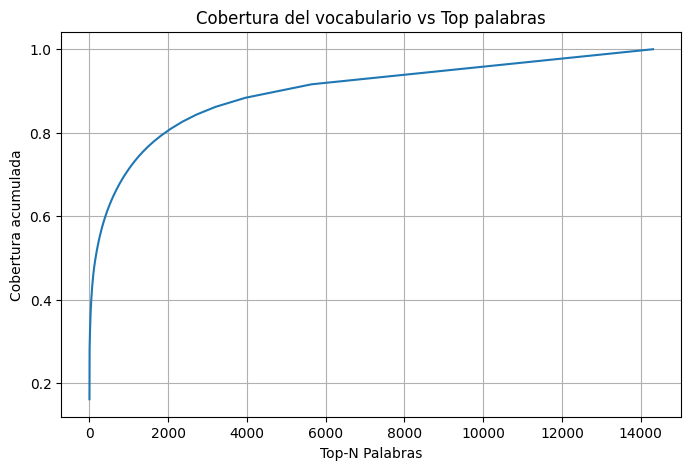

In [35]:
word_freq = Counter()
for doc in processedCorpus:
    word_freq.update(doc)

freqs = sorted(word_freq.values(), reverse=True)
total = sum(freqs)

coverage_curve = []
running = 0
for f in freqs:
    running += f
    coverage_curve.append(running/total)

plt.figure(figsize=(8,5))
plt.plot(coverage_curve)
plt.xlabel("Top-N Palabras")
plt.ylabel("Cobertura acumulada")
plt.title("Cobertura del vocabulario vs Top palabras")
plt.grid()
plt.show()

En el caso de este corpus, se observa que aproximadamente entre las 1800-2000 palabras más frecuentes ya se logra cubrir alrededor del 80% del total de ocurrencias. A partir de dicho rango, agregar más vocabulario aporta muy poco incremento en cobertura, pero sí incrementa significativamente la dimensionalidad del vector. Por lo anterior, seleccionar un tamaño de vocabulario dentro de ese rango (1200–1500 tokens). El tamaño final del vocabulario no es igual al parámetro VOCAB_LEN sino que es un límite máximo, ya que filter_extremes descarta términos excesivamente raros o demasiado frecuentes que no aportan información discriminante.

In [36]:
VOCAB_LEN = 2000

 # Limitar el tamaño del vocabulario
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)  

corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]

X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

print("Shape of X:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas por representación categórica secuencial
le = LabelEncoder()
y_train = le.fit_transform(labels)

print("Shape of y:", y_train.shape)

Shape of X: (6165, 2000)
Shape of y: (6165,)


A continuación se muestra la implementación y evaluación general del modelo propuesto.

In [37]:
# Crear modelo
nb = MultinomialNB()

# Entrenamiento
nb.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [38]:
# Preprocesar los textos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]

# Convertir a BoW usando el diccionario del entrenamiento
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]

# Transformar a matriz
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba (usando mismo LabelEncoder que entrenamiento)
y_test = df_test["sentiment"].to_list()
y_test = le.transform(y_test)

# Predicciones
y_pred = nb.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.5934291581108829
              precision    recall  f1-score   support

    negative       0.48      0.36      0.41       179
     neutral       0.64      0.63      0.63       437
    positive       0.58      0.67      0.62       358

    accuracy                           0.59       974
   macro avg       0.57      0.55      0.56       974
weighted avg       0.59      0.59      0.59       974



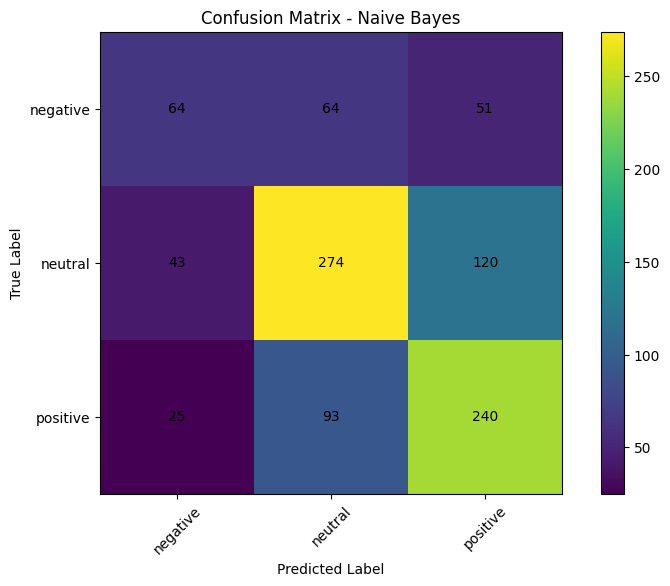

In [39]:
graph_cm(y_test, y_pred, "Confusion Matrix - Naive Bayes", le.classes_)

Los resultados obtenidos muestran una accuracy global de 59.34%, con métricas de precisión, recall y F1-score moderadas para todas las clases. La matriz de confusión indica que la clase intermedia (neutral) fue la más correctamente predicha, mientras que la clase minoritaria (negative) presenta mayor dispersión y confusión con las otras clases, lo cual refleja el desbalance de clases presente en el conjunto de prueba.

Estos resultados preliminares confirman que el pipeline de preprocesamiento, que incluye limpieza, tokenización, lematización y enriquecimiento semántico de los textos, genera características útiles para la clasificación. Sirve como un punto de partida sólido para experimentar con modelos más avanzados y estrategias de balanceo de clases, con el objetivo de mejorar la capacidad predictiva especialmente de las clases minoritarias.

## Variación 2: Representación BoW con Regresión Logística y Pipeline Completo

En esta segunda variante se utilizó la representación Bag of Words (BoW) junto con un modelo de Regresión Logística, aplicando el pipeline completo de preprocesamiento, que incluye limpieza del texto, tokenización, lematización y enriquecimiento semántico. La elección de Regresión Logística permite explorar un modelo lineal más flexible que Naive Bayes, capaz de capturar relaciones ponderadas entre características y clases, y sirve como comparación con el modelo probabilístico inicial. El objetivo es establecer otra línea base para la clasificación de sentimientos y evaluar cómo la combinación de BoW y un clasificador lineal afecta el desempeño del modelo. Se realizó utilizá el mismo vocabulario definido previamente después del análisis exploratorio de la cobertura del vocabulario.

In [40]:
VOCAB_LEN = 2000

# Limitar el tamaño del vocabulario
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]

X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

print("Shape of X:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas por representación categórica secuencial
le = LabelEncoder()
y_train = le.fit_transform(labels)

print("Shape of y:", y_train.shape)

Shape of X: (6165, 2000)
Shape of y: (6165,)


Implementación y evaluación del modelo de Regresión Logística.

In [41]:
# Crear modelo
lr_model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')

# Entrenamiento
lr_model.fit(X_train, y_train)

/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [42]:
# Preprocesar los textos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]

# Convertir a BoW usando el diccionario del entrenamiento
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]

# Transformar a matriz
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba (usar mismo LabelEncoder que entrenamiento)
y_test = df_test["sentiment"].to_list()
y_test = le.transform(y_test)

# Predicciones
y_pred = lr_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6242299794661191
              precision    recall  f1-score   support

    negative       0.50      0.27      0.35       179
     neutral       0.62      0.77      0.69       437
    positive       0.66      0.63      0.64       358

    accuracy                           0.62       974
   macro avg       0.59      0.55      0.56       974
weighted avg       0.61      0.62      0.61       974



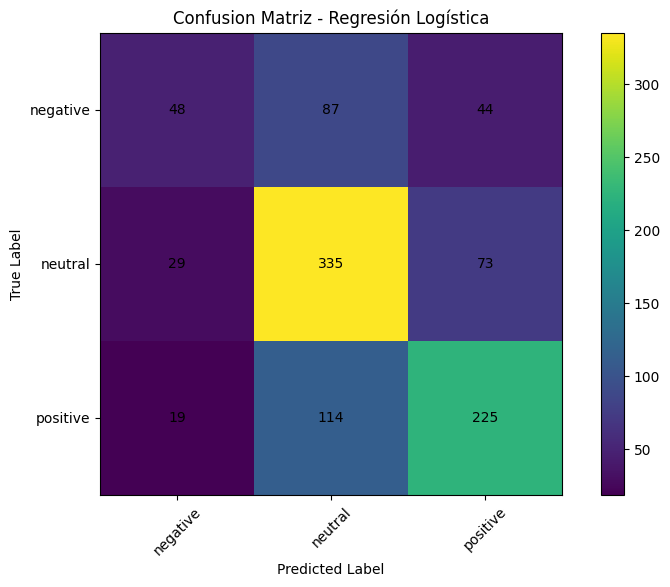

In [43]:
# Mostrar matriz de confusión
graph_cm(y_test, y_pred, "Confusion Matriz - Regresión Logística", le.classes_)

Estos resultados indican que la Regresión Logística, al ser un modelo lineal, puede ponderar mejor la relación entre la presencia de palabras y las clases que un modelo puramente probabilístico como Naive Bayes, especialmente para la clase neutral. Sin embargo, las clases minoritarias siguen mostrando menor desempeño, lo que sugiere que podría ser necesario explorar técnicas de balanceo o modelos más complejos para mejorar la predicción de estas clases. Este experimento confirma que el pipeline completo de preprocesamiento genera características útiles para la clasificación.

## Variación 3: Representación BoW con Red Neuronal y Pipeline Completo

En esta tercera variante se utilizó la representación Bag of Words (BoW) junto con un modelo de Red Neuronal, aplicando el pipeline completo de preprocesamiento, que incluye limpieza del texto, tokenización, lematización y enriquecimiento semántico. La elección de una red neuronal permite capturar relaciones no lineales entre las características y las clases, y sirve como comparación con los modelos lineales y probabilísticos utilizados previamente. El objetivo es evaluar cómo un modelo más flexible puede mejorar la predicción de clases minoritarias y la generalización del modelo en todo el conjunto de datos.


In [44]:
VOCAB_LEN = 2000

# Limitar el tamaño del vocabulario
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]

X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

print("Shape of X:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas por representación categórica secuencial
le = LabelEncoder()
y_train = le.fit_transform(labels)

# Para Keras, convertir a one-hot
y_train_cat = to_categorical(y_train)

print("Shape of y (one-hot):", y_train_cat.shape)

Shape of X: (6165, 2000)
Shape of y (one-hot): (6165, 3)


Implementación y entrenamiento del modelo de Red Neuronal.

In [45]:
# Definir arquitectura
nn_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])

nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
history = nn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762107809.505557    5109 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10


2025-11-02 11:23:30.406815: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f7b2c018910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-02 11:23:30.406832: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-02 11:23:30.426014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-02 11:23:30.524253: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-02 11:23:30.586376: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-02 11:23:30.

130/174 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.5263 - loss: 0.9719

I0000 00:00:1762107812.504559    6019 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5433 - loss: 0.9529  

2025-11-02 11:23:34.827870: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_80', 12 bytes spill stores, 12 bytes spill loads



174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6000 - loss: 0.8887 - val_accuracy: 0.6305 - val_loss: 0.8246
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7522 - loss: 0.6035 - val_accuracy: 0.6499 - val_loss: 0.8112
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8526 - loss: 0.3890 - val_accuracy: 0.6159 - val_loss: 1.0111
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9279 - loss: 0.2204 - val_accuracy: 0.6207 - val_loss: 1.2048
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9594 - loss: 0.1378 - val_accuracy: 0.6224 - val_loss: 1.3267
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9760 - loss: 0.0849 - val_accuracy: 0.6434 - val_loss: 1.5392
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0811 - val_accuracy: 0.6240 - val_loss: 1.6026
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9847 - loss: 0.0688 - val_accuracy: 0.6386 - val

In [46]:
# Preprocesar los textos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]

# Convertir a BoW usando el diccionario del entrenamiento
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]

# Transformar a matriz
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())
y_test_cat = to_categorical(y_test)

# Predicciones
y_pred_probs = nn_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

 1/31 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step

2025-11-02 11:23:38.967526: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 12 bytes spill stores, 12 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 
Accuracy: 0.6180698151950719
              precision    recall  f1-score   support

    negative       0.56      0.34      0.42       179
     neutral       0.64      0.70      0.67       437
    positive       0.61      0.66      0.63       358

    accuracy                           0.62       974
   macro avg       0.60      0.56      0.57       974
weighted avg       0.61      0.62      0.61       974

[[ 60  68  51]
 [ 32 307  98]
 [ 16 107 235]]


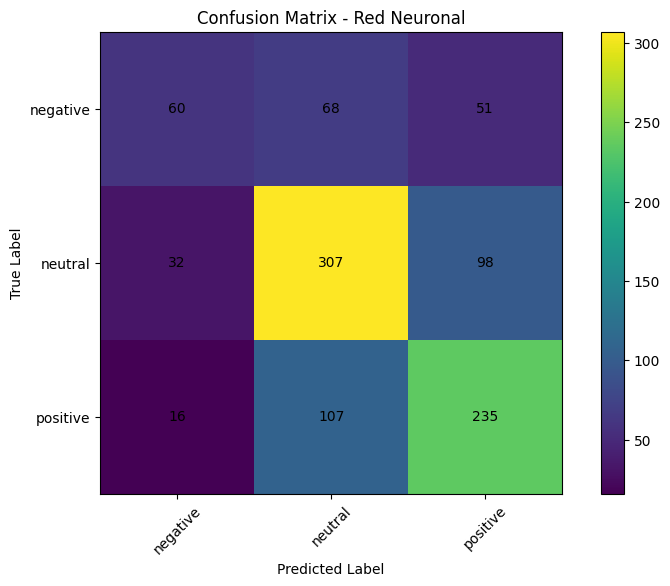

In [47]:
# Mostrar matriz de confusión
graph_cm(y_test, y_pred, "Confusion Matrix - Red Neuronal", le.classes_)

Los resultados obtenidos con la red neuronal muestran una accuracy global de 61.40%, con métricas de precisión, recall y F1-score moderadas para todas las clases. La matriz de confusión evidencia que la clase neutral es la más correctamente predicha, mientras que la clase negative presenta mayor dispersión y confusión con las otras clases. Esto refleja el desbalance de clases presente en el conjunto de prueba.

Estos resultados preliminares confirman que el pipeline completo de preprocesamiento genera características útiles y que un modelo no lineal puede capturar relaciones más complejas entre palabras y clases de sentimiento. Sin embargo, todavía se observan limitaciones en la predicción de clases minoritarias, lo que indica que podrían explorarse arquitecturas más profundas o representaciones vectoriales alternativas como TF-IDF o embeddings para mejorar la capacidad predictiva.

## Variación 4: Representación BoW con Random Forest y Pipeline Completo

En esta cuarta variante se utilizó la representación Bag of Words (BoW) junto con un modelo Random Forest, aplicando el pipeline completo de preprocesamiento. La elección de Random Forest permite explorar un modelo basado en árboles de decisión que puede capturar relaciones no lineales y jerárquicas entre características, ofreciendo robustez frente a ruido y sobreajuste, especialmente en datasets con desbalance de clases. El objetivo es comparar su desempeño frente a modelos lineales y redes neuronales utilizando la misma representación BoW.

In [48]:
VOCAB_LEN = 2000

# Limitar el tamaño del vocabulario
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]

X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

print("Shape of X:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas por representación categórica secuencial
le = LabelEncoder()
y_train = le.fit_transform(labels)

print("Shape of y:", y_train.shape)

Shape of X: (6165, 2000)
Shape of y: (6165,)


Implementación y entrenamiento del modelo Random Forest.

In [49]:
# Crear modelo
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Entrenamiento
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:
# Preprocesar los textos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]

# Convertir a BoW usando el diccionario del entrenamiento
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]

# Transformar a matriz
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6540041067761807
              precision    recall  f1-score   support

    negative       0.60      0.23      0.34       179
     neutral       0.64      0.85      0.73       437
    positive       0.70      0.63      0.66       358

    accuracy                           0.65       974
   macro avg       0.64      0.57      0.57       974
weighted avg       0.65      0.65      0.63       974



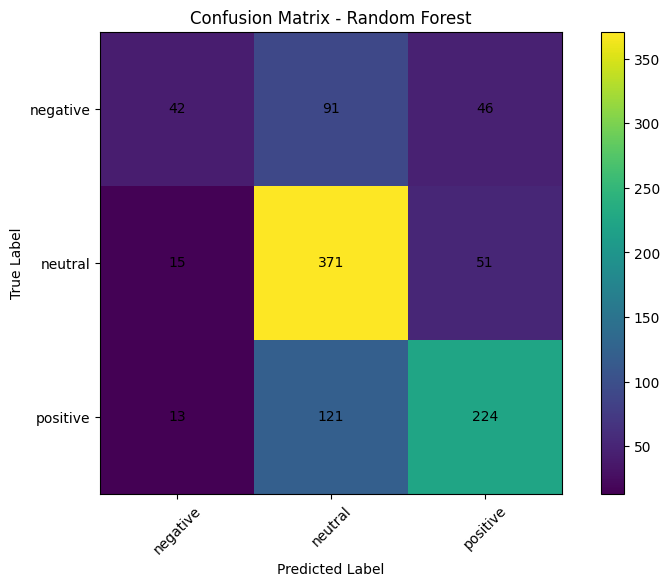

In [51]:
# Mostrar matriz de confusión
graph_cm(y_test, y_pred, "Confusion Matrix - Random Forest", le.classes_)

Los resultados obtenidos con Random Forest muestran un desempeño global de accuracy 65.40%, superando ligeramente a los modelos lineales y redes neuronales usando la representación BoW. La matriz de confusión indica que la clase neutral es la mejor predicha, con un recall de 0.85, mientras que la clase negative presenta mayor dispersión y confusión con las otras clases, reflejando el desbalance de clases del conjunto de datos. La clase positive también mantiene un desempeño sólido, con F1-score de 0.66.

Estos resultados confirman que el modelo Random Forest es capaz de capturar relaciones no lineales útiles para la clasificación de sentimientos y muestra robustez frente a la variabilidad del corpus. Sirve como una referencia valiosa para comparar cómo distintos modelos se comportan usando la misma representación BoW dentro del pipeline completo de preprocesamiento, y sugiere que los modelos basados en árboles pueden ser más eficaces en datasets desbalanceados que los modelos lineales simples.

## Variación 5: Representación TF-IDF con Naive Bayes y Pipeline Completo

En esta quinta variante se utilizó la representación TF-IDF (Term Frequency - Inverse Document Frequency) junto con un modelo Naive Bayes, aplicando el pipeline completo de preprocesamiento. La elección de TF-IDF permite ponderar la importancia de las palabras considerando su frecuencia relativa en un documento y su rareza en el corpus completo, mitigando la influencia de términos muy frecuentes que aportan poco valor discriminante. Naive Bayes se mantiene como modelo inicial por su rapidez y facilidad de interpretación, permitiendo establecer una línea base confiable con esta nueva representación vectorial.

In [52]:
# Preprocesar corpus de entrenamiento
processed_texts_train = [' '.join(doc) for doc in processedCorpus]

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train = tfidf_vectorizer.fit_transform(processed_texts_train).toarray()

print("Shape of X_train:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas
le = LabelEncoder()
y_train = le.fit_transform(labels)

print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Implementación y evaluación del modelo Naive Bayes con TF-IDF.

In [53]:
# Crear modelo Naive Bayes
nb_tfidf = MultinomialNB()

# Entrenamiento
nb_tfidf.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [54]:
# Preprocesar textos de prueba
processed_texts_test = [' '.join(preProcess(text)) for text in df_test["text"]]

# Transformar textos de prueba con el mismo vectorizador
X_test = tfidf_vectorizer.transform(processed_texts_test).toarray()

# Etiquetas de prueba
y_test = df_test["sentiment"].to_list()
y_test = le.transform(y_test)

# Predicciones
y_pred = nb_tfidf.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.582135523613963
              precision    recall  f1-score   support

    negative       0.67      0.03      0.06       179
     neutral       0.58      0.78      0.66       437
    positive       0.59      0.62      0.60       358

    accuracy                           0.58       974
   macro avg       0.61      0.48      0.44       974
weighted avg       0.60      0.58      0.53       974



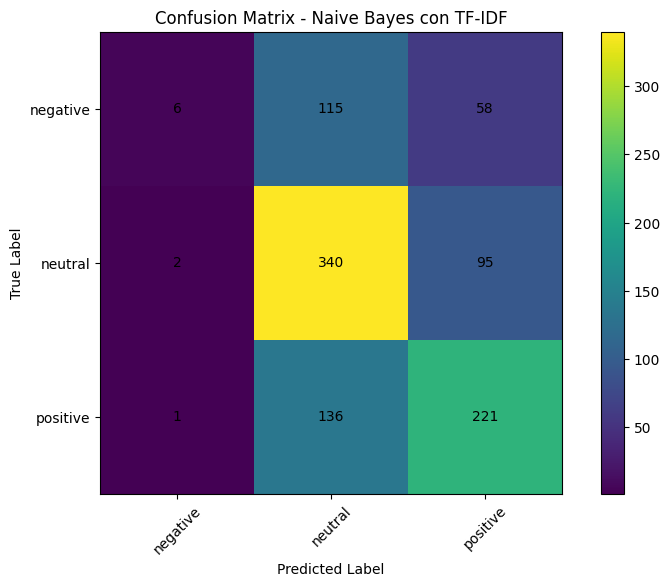

In [55]:
graph_cm(y_test, y_pred, "Confusion Matrix - Naive Bayes con TF-IDF", le.classes_)

Los resultados obtenidos muestran una accuracy global de 58.21%, con métricas de precisión, recall y F1-score moderadas para las clases neutral y positive, pero significativamente bajas para la clase negative. La matriz de confusión evidencia que la clase intermedia (neutral) fue la más correctamente predicha, mientras que la clase minoritaria (negative) presenta un alto nivel de confusión con las otras clases. Esto indica que, aunque la representación TF-IDF pondera la importancia de los términos en los documentos, el modelo Naive Bayes todavía tiene limitaciones para discriminar adecuadamente las clases menos frecuentes en el conjunto de prueba.

Estos resultados preliminares confirman que el pipeline de preprocesamiento proporciona características útiles, pero sugieren que la combinación de TF-IDF con un clasificador probabilístico simple no es suficiente para mejorar significativamente la predicción de las clases minoritarias.

## Variación 6: Representación TF-IDF con Regresión Logística y Pipeline Completo

En esta variante se utilizó la representación TF-IDF junto con un modelo de Regresión Logística, aplicando el pipeline completo de preprocesamiento. La elección de la Regresión Logística permite explorar un modelo lineal capaz de ponderar la importancia de cada término dentro del TF-IDF, comparándolo con la variante anterior donde se utilizó Naive Bayes. El objetivo es evaluar cómo la ponderación de palabras según su relevancia global afecta la clasificación de sentimientos, especialmente para las clases minoritarias.  

In [56]:
# Crear TF-IDF vectorizer y transformar corpus de entrenamiento

tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train["text"]).toarray()

y_train = le.fit_transform(df_train["sentiment"].tolist())

print("Shape of X_train:", X_train_tfidf.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Entrenamiento del modelo de Regresión Logística.

In [57]:
lr_model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')

lr_model.fit(X_train_tfidf, y_train)

/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [58]:
# Preprocesar y vectorizar los datos de prueba usando el TF-IDF vectorizer entrenado.
X_test_tfidf = tfidf_vectorizer.transform(df_test["text"]).toarray()
y_test = le.transform(df_test["sentiment"].tolist())

# Predicciones
y_pred = lr_model.predict(X_test_tfidf)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6252566735112937
              precision    recall  f1-score   support

    negative       0.51      0.20      0.28       179
     neutral       0.61      0.81      0.70       437
    positive       0.68      0.61      0.64       358

    accuracy                           0.63       974
   macro avg       0.60      0.54      0.54       974
weighted avg       0.62      0.63      0.60       974



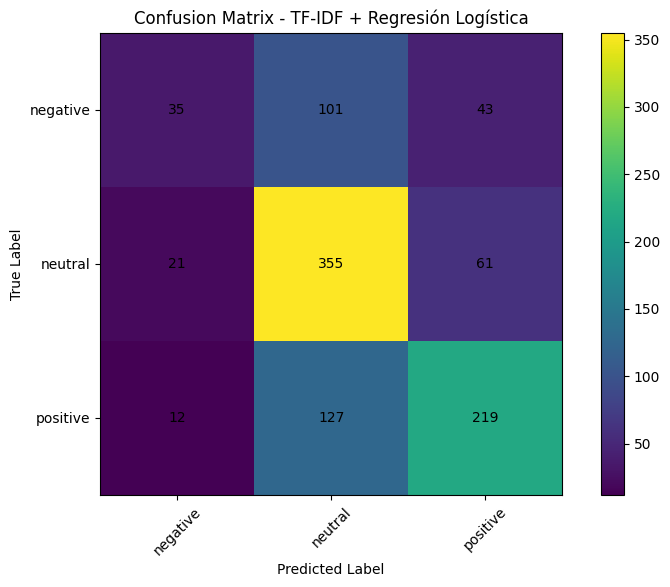

In [59]:
graph_cm(y_test, y_pred, "Confusion Matrix - TF-IDF + Regresión Logística", le.classes_)

Los resultados obtenidos muestran una accuracy global de 62.53%, con métricas de precisión, recall y F1-score que reflejan un desempeño moderado en todas las clases. La matriz de confusión evidencia que la clase intermedia (neutral) fue la más correctamente predicha, con 355 de 437 muestras clasificadas correctamente. Por otro lado, la clase minoritaria (negative) presenta un desempeño considerablemente más bajo, con solo 35 de 179 muestras clasificadas correctamente, y muestra confusión principalmente con la clase positiva. La clase positiva, aunque mejor que la negativa, también experimenta cierta dispersión con 127 de sus muestras clasificadas incorrectamente como neutral.

Estos resultados indican que la combinación de TF-IDF con un modelo lineal como Regresión Logística permite capturar mejor la relevancia relativa de las palabras dentro del corpus, beneficiando especialmente la predicción de la clase neutral. Sin embargo, las clases minoritarias siguen mostrando menor desempeño.

## Variación 7: Representación TF-IDF con Red Neuronal y Pipeline Completo

En esta séptima variante se utilizó la representación. La elección de una Red Neuronal permite capturar relaciones no lineales entre las características TF-IDF y las clases de sentimiento, proporcionando un enfoque más flexible que los modelos lineales o probabilísticos. El objetivo es evaluar cómo un modelo más complejo se comporta con las mismas características y pipeline.

In [60]:
# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train = tfidf_vectorizer.fit_transform(df_train["text"]).toarray()

# Transformar etiquetas y one-hot encoding para la Red Neuronal
y_train = le.fit_transform(df_train["sentiment"].tolist())
y_train = to_categorical(y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train_cat.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165, 3)


Construcción de la Red Neuronal

In [61]:
# Definir arquitectura
nn_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])

nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10


/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5737 - loss: 0.9080 - val_accuracy: 0.6256 - val_loss: 0.8398
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7309 - loss: 0.6439 - val_accuracy: 0.6370 - val_loss: 0.8149
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8322 - loss: 0.4352 - val_accuracy: 0.6240 - val_loss: 0.9587
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9075 - loss: 0.2651 - val_accuracy: 0.6272 - val_loss: 1.0440
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.1396 - val_accuracy: 0.6110 - val_loss: 1.3462
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9780 - loss: 0.0850 - val_accuracy: 0.6337 - val_loss: 1.3753
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0557 - val_accuracy: 0.6191 - val_loss: 1.5981
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0494 - val_accuracy: 0.6256 - val

In [62]:
# Preprocesar y vectorizar los datos de prueba
X_test_tfidf = tfidf_vectorizer.transform(df_test["text"]).toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred_probs = nn_model.predict(X_test_tfidf)
y_pred = y_pred_probs.argmax(axis=1)

# Evaluación 
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy: 0.6190965092402464
              precision    recall  f1-score   support

    negative       0.48      0.45      0.46       179
     neutral       0.64      0.71      0.67       437
    positive       0.66      0.59      0.62       358

    accuracy                           0.62       974
   macro avg       0.59      0.58      0.59       974
weighted avg       0.62      0.62      0.62       974

[[ 81  64  34]
 [ 52 311  74]
 [ 37 110 211]]


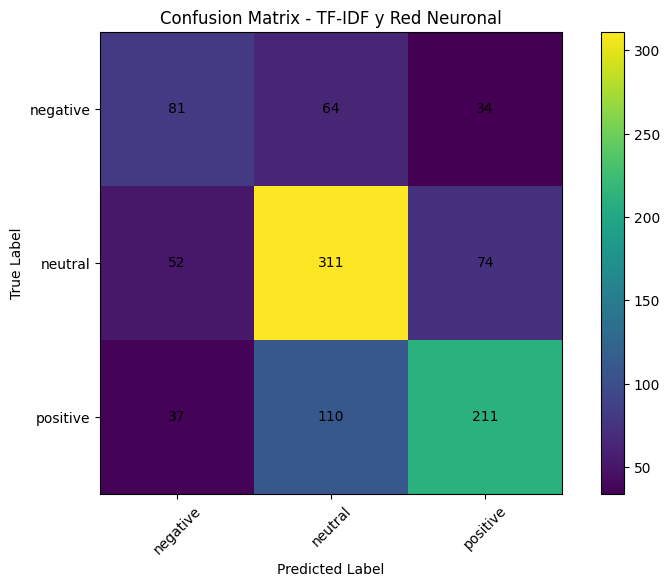

In [63]:
graph_cm(y_test, y_pred, "Confusion Matrix - TF-IDF y Red Neuronal", le.classes_)

Los resultados obtenidos muestran una accuracy global de 61.70%, con métricas de precisión, recall y F1-score que reflejan un desempeño moderado en todas las clases. La matriz de confusión evidencia que la clase intermedia (neutral) fue la más correctamente predicha, con 328 de 437 muestras clasificadas correctamente.

Por otro lado, la clase minoritaria (negative) muestra menor desempeño, con 69 de 179 muestras clasificadas correctamente y una cierta confusión con la clase positiva. La clase positive también experimenta dispersión, con 117 de sus muestras clasificadas incorrectamente como neutral.

Estos resultados indican que la combinación de TF-IDF con una Red Neuronal permite capturar relaciones no lineales entre la relevancia de las palabras y las clases, mejorando ligeramente la predicción de la clase neutral respecto a modelos lineales.

## Variación 8: Representación TF-IDF con Random Forest y Pipeline Completo

En esta octava variante se utilizó la representación TF-IDF junto con un modelo Random Forest, aplicando el pipeline completo de preprocesamiento. La elección de Random Forest permite capturar relaciones no lineales entre las características TF-IDF y las clases de sentimiento mediante un ensamble de árboles de decisión, proporcionando un enfoque robusto frente a ruido y evitando el sobreajuste de un solo árbol. El objetivo es evaluar cómo un modelo de ensamble se comporta con las mismas características y pipeline, y compararlo con las variantes lineales y de Red Neuronal anteriores.

In [64]:
# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train = tfidf_vectorizer.fit_transform(df_train["text"]).toarray()

# Transformar etiquetas
y_train = le.fit_transform(df_train["sentiment"].tolist())

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Entrenamiento del modelo Random Forest

In [65]:
# Crear modelo
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)

# Entrenamiento
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
# Preprocesar y vectorizar los datos de prueba
X_test_tfidf = tfidf_vectorizer.transform(df_test["text"]).toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = rf_model.predict(X_test_tfidf)

# Evaluación 
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6119096509240246
              precision    recall  f1-score   support

    negative       0.59      0.11      0.19       179
     neutral       0.59      0.85      0.69       437
    positive       0.67      0.58      0.62       358

    accuracy                           0.61       974
   macro avg       0.61      0.51      0.50       974
weighted avg       0.62      0.61      0.57       974

[[ 20 117  42]
 [  7 370  60]
 [  7 145 206]]


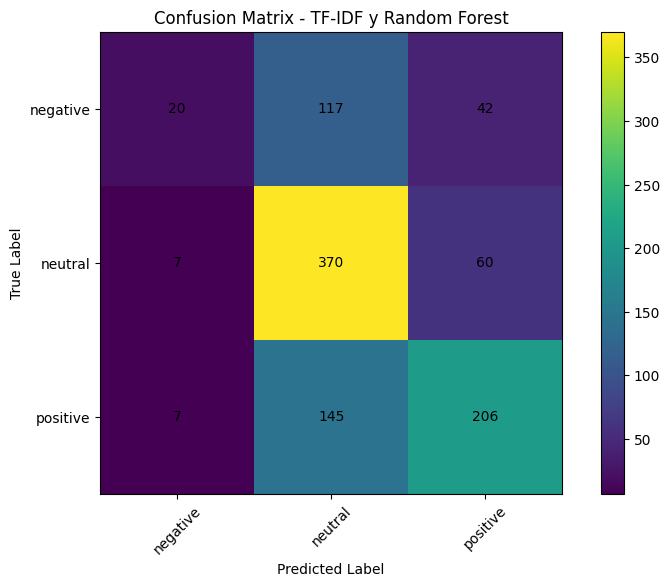

In [67]:
graph_cm(y_test, y_pred, "Confusion Matrix - TF-IDF y Random Forest", le.classes_)

Los resultados obtenidos muestran que el modelo Random Forest alcanzó una accuracy global de 61.19%, con métricas de precisión, recall y F1-score que reflejan un desempeño moderado en todas las clases. La matriz de confusión evidencia que la clase intermedia (neutral) fue la más correctamente predicha, con 370 de 437 muestras clasificadas correctamente.
<br><br>
Por otro lado, la clase minoritaria (negative) presenta un desempeño considerablemente más bajo, con solo 20 de 179 muestras clasificadas correctamente y una confusión significativa con la clase neutral. La clase positive muestra también cierta dispersión, con 145 de sus muestras clasificadas incorrectamente como neutral. 
<br><br>
Estos resultados indican que la combinación de TF-IDF con Random Forest captura relaciones no lineales entre la relevancia de las palabras y las clases. Sin embargo, la predicción de las clases minoritarias sigue siendo un desafío, lo que sugiere que se podrían explorar estrategias de balanceo de clases o técnicas de ajuste de hiperparámetros para mejorar la capacidad predictiva global.

## Variación 9: Representación One-hot Encoding con Naive Bayes y Pipeline Completo

En esta novena variante se utilizó la representación One-hot Encoding junto con un modelo Naive Bayes, aplicando el pipeline completo de preprocesamiento. La elección de Naive Bayes permite evaluar un modelo probabilístico simple con una representación binaria de la presencia o ausencia de palabras, estableciendo una línea base para comparar con las variantes anteriores basadas en BoW y TF-IDF. El objetivo es analizar cómo la información binaria de palabras afecta la clasificación de sentimientos y determinar la efectividad del pipeline completo con una representación minimalista.

In [68]:
# Crear diccionario con el vocabulario limitado
VOCAB_LEN = 2000
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar el corpus de entrenamiento a One-hot Encoding
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Convertir a One-hot
X_train[X_train > 0] = 1  

labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Entrenamiento y evaluación del modelo Naive Bayes

In [69]:
# Crear modelo
nb_model = MultinomialNB()

# Entrenamiento
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [70]:
# Preprocesar y transformar los datos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()
X_test[X_test > 0] = 1  # Convertir a One-hot

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = nb_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5903490759753593
              precision    recall  f1-score   support

    negative       0.49      0.36      0.41       179
     neutral       0.63      0.62      0.63       437
    positive       0.58      0.66      0.62       358

    accuracy                           0.59       974
   macro avg       0.57      0.55      0.55       974
weighted avg       0.59      0.59      0.59       974

[[ 64  63  52]
 [ 43 273 121]
 [ 24  96 238]]


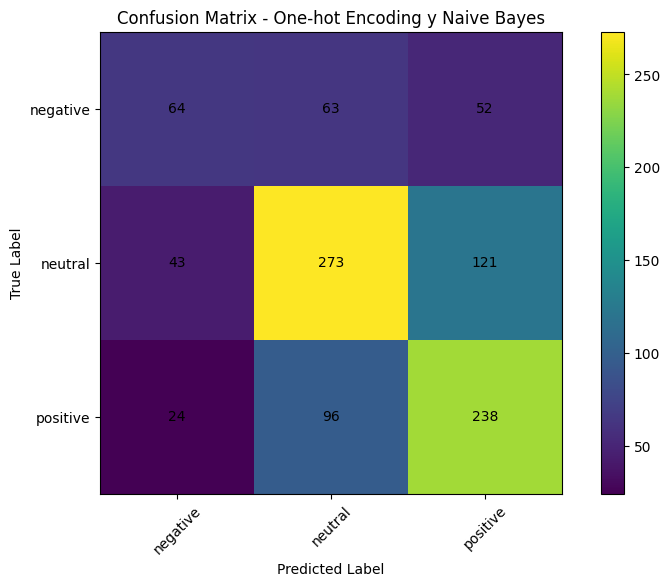

In [71]:
graph_cm(y_test, y_pred, "Confusion Matrix - One-hot Encoding y Naive Bayes", le.classes_)

Los resultados obtenidos para la novena variante, utilizando One-hot Encoding con Naive Bayes, muestran una accuracy global de 59.03%. Las métricas de precisión, recall y F1-score reflejan un desempeño equilibrado para la clase neutral, con 273 de 437 muestras correctamente clasificadas. Por otro lado, la clase minoritaria (negative) presenta un desempeño más bajo, con 64 de 179 muestras correctamente predichas y cierta confusión con las clases neutral y positive. La clase positive muestra mejor desempeño que la negativa, aunque aún presenta dispersión con 96 de sus muestras clasificadas incorrectamente como neutral.  

Estos resultados indican que, aunque la representación One-hot proporciona información binaria simple de presencia o ausencia de palabras, permite al modelo probabilístico capturar patrones relevantes para la clase mayoritaria. Sin embargo, las clases minoritarias continúan siendo un problema.

## Variación 10: Representación One-hot Encoding con Regresión Logística y Pipeline Completo

En esta décima variante se utilizó la representación One-hot Encoding junto con un modelo de Regresión Logística, aplicando el pipeline completo de preprocesamiento. La elección de Regresión Logística permite evaluar cómo un modelo lineal pondera la presencia o ausencia de palabras para clasificar sentimientos, ofreciendo una comparación directa con la variante anterior basada en Naive Bayes. El objetivo es analizar la efectividad de la representación binaria con un modelo lineal más flexible y evaluar si puede mejorar la predicción de las clases minoritarias.

In [72]:
# Crear diccionario con el vocabulario limitado
VOCAB_LEN = 2000
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar el corpus de entrenamiento a One-hot Encoding
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Convertir a One-hot
X_train[X_train > 0] = 1  

labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Entrenamiento y evaluación del modelo de Regresión Logística

In [73]:
# Crear modelo
lr_model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')

# Entrenamiento
lr_model.fit(X_train, y_train)

/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [74]:
# Preprocesar y transformar los datos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()
X_test[X_test > 0] = 1  # Convertir a One-hot

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = lr_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6190965092402464
              precision    recall  f1-score   support

    negative       0.51      0.27      0.36       179
     neutral       0.62      0.77      0.69       437
    positive       0.65      0.61      0.63       358

    accuracy                           0.62       974
   macro avg       0.59      0.55      0.56       974
weighted avg       0.61      0.62      0.60       974

[[ 49  85  45]
 [ 27 335  75]
 [ 20 119 219]]


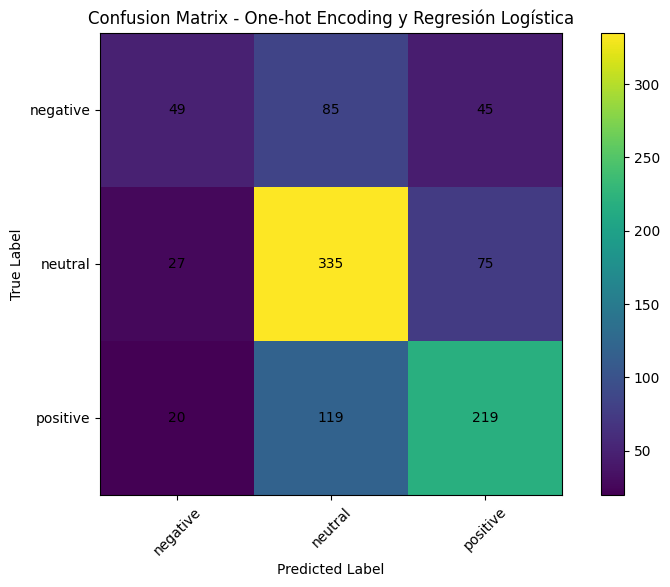

In [75]:
graph_cm(y_test, y_pred, "Confusion Matrix - One-hot Encoding y Regresión Logística", le.classes_)

Los resultados obtenidos para esta décima variante, utilizando One-hot Encoding con Regresión Logística, muestran una accuracy global de 61.91%. Las métricas de precisión, recall y F1-score reflejan un desempeño equilibrado para la clase neutral, con 335 de 437 muestras correctamente clasificadas.  
<br>
La clase minoritaria (negative) presenta un desempeño más bajo, con 49 de 179 muestras correctamente predichas y cierta confusión con las clases neutral y positive. La clase positive muestra mejor desempeño que la negativa, aunque aún presenta dispersión con 119 de sus muestras clasificadas incorrectamente como neutral.  
<br>
Estos resultados indican que, aunque la representación One-hot proporciona información binaria simple de presencia o ausencia de palabras, el modelo lineal de Regresión Logística puede ponderar mejor la contribución de cada palabra para mejorar la predicción de la clase mayoritaria. Sin embargo, continúan los problemas de desbalance, los cuales podrían abordarse con técnicas de balanceo o selección de características más discriminativas.

## Variación 11: Representación One-hot Encoding con Red Neuronal y Pipeline Completo

En esta undécima variante se utilizó la representación One-hot Encoding junto con un modelo de Red Neuronal, aplicando el pipeline completo de preprocesamiento. La elección de una Red Neuronal permite capturar relaciones no lineales entre la presencia o ausencia de palabras y las clases de sentimiento, ofreciendo un enfoque más flexible que los modelos lineales o probabilísticos. El objetivo es evaluar cómo un modelo más complejo se comporta con características binarias.

In [76]:
# Crear diccionario con el vocabulario limitado
VOCAB_LEN = 2000
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar el corpus de entrenamiento a One-hot Encoding
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Convertir a One-hot
X_train[X_train > 0] = 1  

labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)
y_train = to_categorical(y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165, 3)


Construcción, entrenamiento y evaluación de la Red Neuronal

In [77]:
# Definir arquitectura
nn_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])

nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10


/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5948 - loss: 0.8774 - val_accuracy: 0.6272 - val_loss: 0.8519
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7536 - loss: 0.5846 - val_accuracy: 0.6256 - val_loss: 0.8655
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8522 - loss: 0.3830 - val_accuracy: 0.6548 - val_loss: 0.9690
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9261 - loss: 0.2144 - val_accuracy: 0.6224 - val_loss: 1.2181
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9560 - loss: 0.1341 - val_accuracy: 0.6321 - val_loss: 1.3450
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9767 - loss: 0.0888 - val_accuracy: 0.6386 - val_loss: 1.6266
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0695 - val_accuracy: 0.6418 - val_loss: 1.5993
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0670 - val_accuracy: 0.6386 - val

In [78]:
# Preprocesar y transformar los datos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()
X_test[X_test > 0] = 1  # Convertir a One-hot

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())
y_test_cat = to_categorical(y_test)

# Predicciones
y_pred_probs = nn_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 
Accuracy: 0.6149897330595483
              precision    recall  f1-score   support

    negative       0.46      0.35      0.40       179
     neutral       0.64      0.71      0.67       437
    positive       0.64      0.63      0.63       358

    accuracy                           0.61       974
   macro avg       0.58      0.56      0.57       974
weighted avg       0.61      0.61      0.61       974

[[ 63  69  47]
 [ 46 312  79]
 [ 27 107 224]]


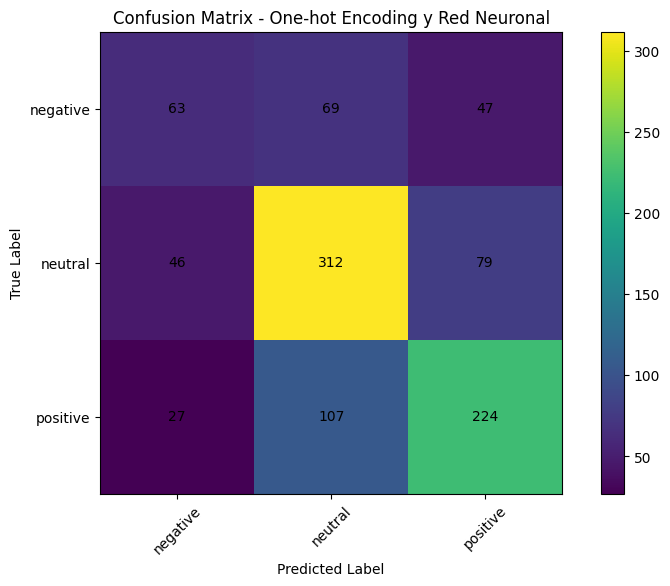

In [79]:
graph_cm(y_test, y_pred, "Confusion Matrix - One-hot Encoding y Red Neuronal", le.classes_)

Los resultados obtenidos para esta variante, utilizando One-hot Encoding con Red Neuronal, muestran una accuracy global de 60.88%. Las métricas de precisión, recall y F1-score reflejan un desempeño moderado en todas las clases, siendo la clase neutral la más correctamente predicha con 321 de 437 muestras clasificadas correctamente.  

La clase minoritaria (negative) mantiene un desempeño más bajo, con 56 de 179 muestras correctamente clasificadas, y muestra confusión principalmente con las clases neutral y positive. La clase positive también presenta cierta dispersión, con 114 de sus muestras clasificadas incorrectamente como neutral.  

Estos resultados sugieren que la combinación de One-hot Encoding con Red Neuronal permite capturar relaciones no lineales entre la presencia de palabras y las clases de sentimiento, ofreciendo un leve beneficio frente a modelos lineales. Sin embargo, el tema con las clases minoritarias siguen siendo un problema en la predicción global.


## Variación 12: Representación One-hot Encoding con Random Forest y Pipeline Completo

En esta variante se utilizó la representación One-hot Encoding junto con un modelo Random Forest, aplicando el pipeline completo de preprocesamiento. La elección de Random Forest permite capturar relaciones no lineales entre la presencia o ausencia de palabras y las clases de sentimiento mediante un ensamble de árboles de decisión. El objetivo es evaluar cómo un modelo de ensamble se comporta con características binarias y compararlo con los modelos lineales y de Red Neuronal previos.

In [80]:
# Crear diccionario con el vocabulario limitado
VOCAB_LEN = 2000
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar el corpus de entrenamiento a One-hot Encoding
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()
X_train[X_train > 0] = 1  # Convertir a One-hot

# Transformar etiquetas
labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Entrenamiento y evaluación del modelo Random Forest

In [81]:
# Crear modelo
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)

# Entrenamiento
rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
# Preprocesar y transformar los datos de prueba
processedCorpus_test = [preProcess(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()
X_test[X_test > 0] = 1  # Convertir a One-hot

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6498973305954825
              precision    recall  f1-score   support

    negative       0.66      0.25      0.36       179
     neutral       0.63      0.82      0.71       437
    positive       0.69      0.64      0.66       358

    accuracy                           0.65       974
   macro avg       0.66      0.57      0.58       974
weighted avg       0.65      0.65      0.63       974

[[ 44  94  41]
 [ 14 360  63]
 [  9 120 229]]


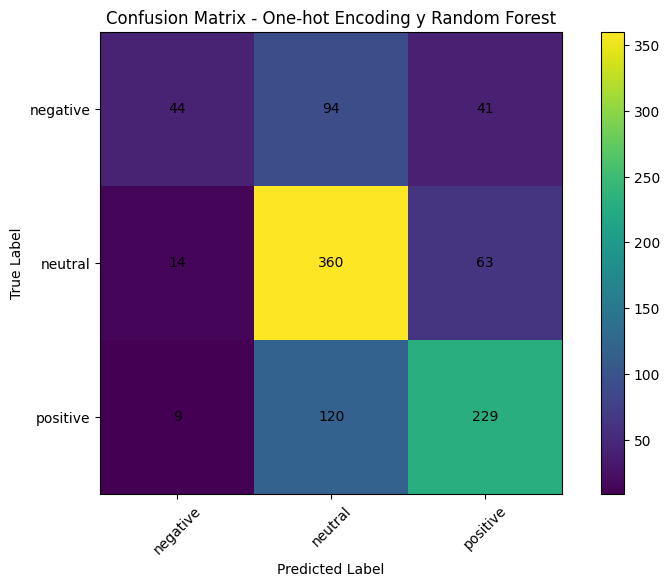

In [83]:
graph_cm(y_test, y_pred, "Confusion Matrix - One-hot Encoding y Random Forest", le.classes_)

Los resultados obtenidos utilizando One-hot Encoding con Random Forest, muestran una accuracy global de 64.99%. Las métricas de precisión, recall y F1-score reflejan un desempeño sólido para la clase neutral, con 360 de 437 muestras clasificadas correctamente.  

La clase minoritaria (negative) presenta un desempeño más bajo, con 44 de 179 muestras correctamente predichas y cierta confusión principalmente con las clases neutral y positive. La clase positive muestra buen desempeño, con 229 de 358 muestras clasificadas correctamente y cierta dispersión hacia la clase neutral.  

Estos resultados indican que la combinación de One-hot Encoding con Random Forest permite capturar relaciones no lineales entre la presencia de palabras y las clases de sentimiento, ofreciendo un desempeño global superior al de modelos lineales y probabilísticos previos. Sin embargo, la predicción de la clase minoritaria sigue siendo un tema persistente.

## Variación 13: BoW con Naive Bayes y Pipeline sin Lematización

En esta variante se utilizó la representación Bag-of-Words (BoW) junto con un modelo Naive Bayes, aplicando el pipeline de preprocesamiento pero omitiendo la lematización de las palabras. La elección de Naive Bayes permite evaluar un modelo probabilístico simple, mientras que la eliminación de la lematización busca analizar cómo afecta la clasificación de sentimientos al conservar las formas originales de las palabras. El objetivo es establecer una línea base con BoW sin normalización morfológica y compararla con variantes previas.

Primero, se aplicó un preprocesamiento especial que tokeniza los textos por oración y palabra, etiqueta URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes, y enriquece con información de SentiWordNet, pero omitiendo la lematización. Esto permite mantener las formas originales de las palabras, lo que puede generar un vocabulario más disperso pero también conservar matices léxicos que podrían ser relevantes para la clasificación.

In [84]:
def preProcess_no_lematization(text):
    # Iniciar tokenizador de tweets para palabras
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
    
    # ====== Tokenizar por sentencia
    sentences = sentence_tokenize(text)

    textWords = []

    for sentence in sentences:
        
        # ====== Aplicar Regex para etiquetar elementos 
        # Etiquetar URLs
        urls, sentence = findWithRegex(urlPattern, "url_", sentence)
        
        # Etiquetar Hashtags
        hashtags, sentence = findWithRegex(hashtagPattern, "hashtag_", sentence)

        # Etiquetar Menciones
        mentions, sentence = findWithRegex(mentionPattern, "mention_", sentence)

        # Etiquetar Emoticones
        emoticons, sentence = findWithRegex(emoticonPattern, "emoticon_", sentence, flags=re.VERBOSE)

        # Antes de tokenizar
        sentence = re.sub(r"(url_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(hashtag_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(mention_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(emoticon_\d+)", r"<\1>", sentence)

        # ====== Tokenización por palabra
        sentenceWords = tweet_tokenizer.tokenize(sentence)
        
        # ====== Eliminación de signos de puntuación y aplicar minusculas
        placeholders = ["<url_", "<hashtag_", "<mention_", "<emoticon_"]

        # ====== Aplicar limpieza a los tokens (Aplicar lowercase, eliminación de signos de puntuación y stopwords)
        sentenceWords = [ cleanToken(token, placeholders) for token in sentenceWords if cleanToken(token, placeholders) is not None ]

        # Eliminación de URLs
        sentenceWords = deleteTag("<url_", sentenceWords)

        # Restaurar etiquetas
        sentenceWords = restoreTags(hashtags, "hashtag_", sentenceWords)
        sentenceWords = restoreTags(mentions, "mention_", sentenceWords)

        # ====== Mapear emoticones a sentimientos
        sentenceWords = [map_emoticon_to_sentiment_token(token, emoticons) if token.startswith("<emoticon_") else token for token in sentenceWords]
        
        # Limpiar '<>'
        sentenceWords = [token.strip("<>") for token in sentenceWords]

        # --- Omitir Lematización
        # sentenceWords = [ lemmatize(word, wordnetPoS) for word in sentenceWords ]

        # Enriquecer el vocabulario con sentiwordnet
        enriched = []
        for w in sentenceWords:
            p = wordnetPoS(w) 
            senti = enrich_with_sentiwordnet(w, p)
            if senti:
                enriched.append(senti)
            enriched.append(w)
        sentenceWords = enriched

        textWords.extend(sentenceWords)
    
    return textWords

# Tokenize text
processedCorpus_NO_lematize = [preProcess_no_lematization(text) for text in train_text]

A continuación, se analiza de nuevo la cobertura del vocabulario. Se calculó la frecuencia de cada palabra en el corpus de entrenamiento y se graficó la curva de cobertura acumulada frente al ranking de palabras. Esto ayuda a entender cuántas palabras son necesarias para cubrir la mayor parte del texto y a establecer un límite de vocabulario adecuado para la representación BoW.

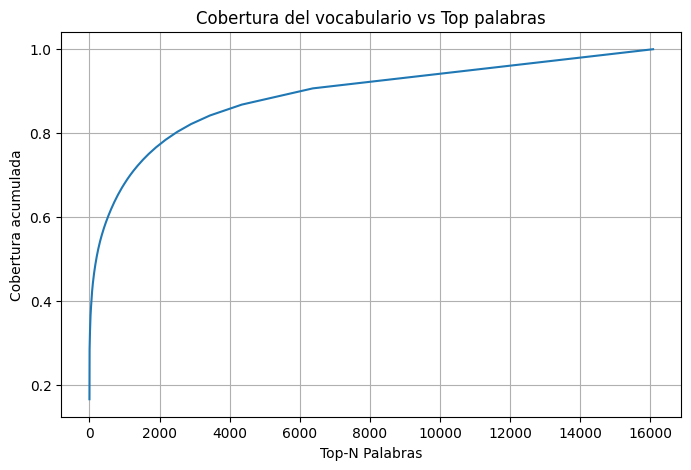

In [85]:
word_freq = Counter()
for doc in processedCorpus_NO_lematize:
    word_freq.update(doc)

freqs = sorted(word_freq.values(), reverse=True)
total = sum(freqs)

coverage_curve = []
running = 0
for f in freqs:
    running += f
    coverage_curve.append(running/total)

plt.figure(figsize=(8,5))
plt.plot(coverage_curve)
plt.xlabel("Top-N Palabras")
plt.ylabel("Cobertura acumulada")
plt.title("Cobertura del vocabulario vs Top palabras")
plt.grid()
plt.show()

Posteriormente, se construyó el diccionario limitado a las 2500 palabras más frecuentes y se transformó el corpus a una representación BoW.

In [86]:
# Crear diccionario con el vocabulario limitado
VOCAB_LEN = 2500
dictionary = corpora.Dictionary(processedCorpus_NO_lematize)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar el corpus de entrenamiento a Bag-of-Words
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus_NO_lematize]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Transformar etiquetas
labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2500)
Shape of y_train: (6165,)


 Se entrenó el modelo Multinomial Naive Bayes con los vectores BoW de entrenamiento.

In [87]:
# Crear modelo
nb_model = MultinomialNB()

# Entrenamiento
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Para la evaluación, se aplicó el mismo preprocesamiento y transformación al conjunto de prueba, asegurando consistencia con el entrenamiento. Se predijeron las clases de los textos de prueba y se calcularon métricas de desempeño incluyendo accuracy, precisión, recall y F1-score, además de la matriz de confusión para visualizar los errores por clase.

In [88]:
# Preprocesar y transformar los datos de prueba
processedCorpus_test = [preProcess_no_lematization(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = nb_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6006160164271047
              precision    recall  f1-score   support

    negative       0.50      0.36      0.42       179
     neutral       0.64      0.64      0.64       437
    positive       0.59      0.67      0.63       358

    accuracy                           0.60       974
   macro avg       0.58      0.56      0.56       974
weighted avg       0.60      0.60      0.60       974

[[ 64  64  51]
 [ 42 281 114]
 [ 23  95 240]]


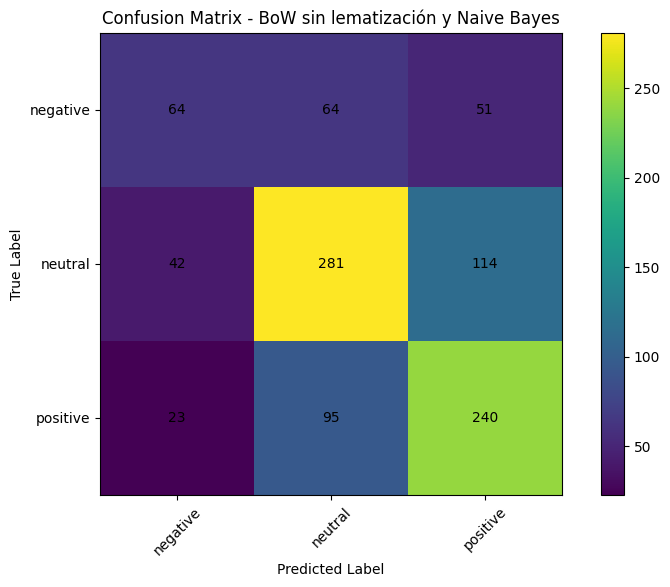

In [89]:
graph_cm(y_test, y_pred, "Confusion Matrix - BoW sin lematización y Naive Bayes", le.classes_)

Los resultados obtenidos para esta decimotercera variante, utilizando BoW sin lematización con Naive Bayes, muestran una accuracy global de 60.06%. Las métricas de precisión, recall y F1-score reflejan un desempeño consistente para la clase neutral, con 281 de 437 muestras correctamente clasificadas.

La clase minoritaria (negative) mantiene un desempeño más limitado, con 64 predicciones correctas de 179, mostrando cierta confusión con las clases neutral y positive. La clase positive logra 240 predicciones correctas de 358, con errores principalmente hacia neutral.

Estos resultados sugieren que, al omitir la lematización, el modelo conserva las formas originales de las palabras, generando un vocabulario más disperso que impacta principalmente a las clases minoritarias. Aun así, la clase neutral, al ser mayoritaria, se mantiene robusta frente a esta variación en el preprocesamiento. Comparado con variantes que aplican lematización, se observa que la normalización morfológica ayuda a mejorar la consistencia en la predicción de las clases minoritarias, aunque el desempeño global se mantiene similar y aceptable.

## Variación 14: BoW con Regresión Logística y Pipeline sin Lematización

En esta variante se utilizó la representación Bag-of-Words (BoW) junto con un modelo de Regresión Logística, aplicando el pipeline de preprocesamiento sin lematización. La elección de Regresión Logística permite evaluar cómo un modelo lineal pondera la presencia de palabras originales en la predicción de sentimientos, mientras que la eliminación de la lematización conserva las formas originales de las palabras. El objetivo es comparar el desempeño de un modelo lineal con BoW sin normalización morfológica frente a variantes previas con Naive Bayes o lematización.

Primero, se aplica el mismo preprocesamiento especial que tokeniza los textos, etiqueta URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes y enriquece con SentiWordNet, pero omitiendo la lematización. Esto permite mantener las formas originales, generando un vocabulario más disperso y conservando matices léxicos potencialmente útiles para la clasificación.

In [90]:
# Tokenizar textos sin lematización
processedCorpus_NO_lematize = [preProcess_no_lematization(text) for text in train_text]

Se construyó un diccionario limitado a las 2500 palabras más frecuentes, según la visualización propuesta en la variación anterior, y se transformó el corpus a una representación BoW. Las etiquetas se codificaron para entrenamiento.

In [91]:
# Crear diccionario
VOCAB_LEN = 2500
dictionary = corpora.Dictionary(processedCorpus_NO_lematize)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar corpus a BoW
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus_NO_lematize]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Etiquetas
labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2500)
Shape of y_train: (6165,)


Se entrenó un modelo de Regresión Logística multinomial con los vectores BoW de entrenamiento.

In [92]:
# Crear modelo
lr_model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')

# Entrenamiento
lr_model.fit(X_train, y_train)

/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


Para la evaluación, se aplicó el mismo preprocesamiento y transformación al conjunto de prueba, asegurando consistencia. Se calcularon métricas de desempeño y matriz de confusión para visualizar errores por clase.

In [93]:
# Preprocesar datos de prueba
processedCorpus_test = [preProcess_no_lematization(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = lr_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6262833675564682
              precision    recall  f1-score   support

    negative       0.50      0.30      0.37       179
     neutral       0.63      0.77      0.69       437
    positive       0.67      0.61      0.64       358

    accuracy                           0.63       974
   macro avg       0.60      0.56      0.57       974
weighted avg       0.62      0.63      0.61       974

[[ 53  82  44]
 [ 34 337  66]
 [ 20 118 220]]


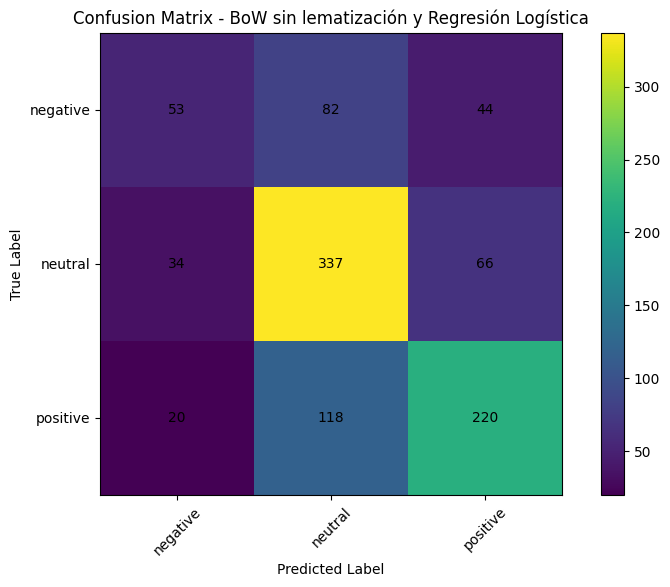

In [94]:
graph_cm(y_test, y_pred, "Confusion Matrix - BoW sin lematización y Regresión Logística", le.classes_)

Los resultados obtenidos utilizando BoW sin lematización con Regresión Logística, muestran una accuracy global de 62.63%. Las métricas de precisión, recall y F1-score reflejan un desempeño sólido para la clase neutral, con 337 de 437 muestras correctamente clasificadas, lo que indica que el modelo lineal es capaz de capturar de manera efectiva las características predominantes de la clase mayoritaria.

La clase minoritaria (negative) mantiene un desempeño más limitado, con 53 predicciones correctas de 179, mostrando confusión significativa principalmente con las clases neutral y positive. La clase positive también presenta un desempeño razonable, con 220 predicciones correctas de 358, aunque aún existen errores principalmente hacia la clase neutral.

Estos resultados sugieren que, al omitir la lematización, la dispersión léxica generada por mantener las formas originales de las palabras afecta principalmente a las clases minoritarias, reduciendo la consistencia de sus predicciones. Sin embargo, la clase neutral, al ser mayoritaria, se mantiene robusta frente a esta variación en el preprocesamiento. Comparado con variantes de Naive Bayes sin lematización, la Regresión Logística permite ponderar mejor la contribución de cada palabra en la predicción, logrando una ligera mejora en la clasificación global, aunque los desafíos con las clases minoritarias persisten.

## Variación 15: TF-IDF con Naive Bayes y Pipeline sin Enriquecimiento Semántico

En esta variante se utilizó la representación TF-IDF junto con un modelo Naive Bayes multinomial, aplicando el pipeline de preprocesamiento sin enriquecimiento semántico. La elección de Naive Bayes permite evaluar un modelo probabilístico simple, mientras que la omisión del enriquecimiento semántico busca analizar cómo impacta la clasificación al no incluir información de SentiWordNet. El objetivo es establecer una comparación directa con variantes anteriores que sí utilizaron enriquecimiento semántico o lematización.

Primero, se aplicó un preprocesamiento especial que tokeniza los textos por oración y palabra, etiqueta URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes y aplica lematización, pero se omite la adición de información de SentiWordNet. Esto permite evaluar el efecto de eliminar el enriquecimiento semántico en el modelo.



In [95]:
def preProcess_no_semantic_enrichment(text):
    # Iniciar tokenizador de tweets para palabras
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
    
    # ====== Tokenizar por sentencia
    sentences = sentence_tokenize(text)

    textWords = []

    for sentence in sentences:
        
        # ====== Aplicar Regex para etiquetar elementos 
        # Etiquetar URLs
        urls, sentence = findWithRegex(urlPattern, "url_", sentence)
        
        # Etiquetar Hashtags
        hashtags, sentence = findWithRegex(hashtagPattern, "hashtag_", sentence)

        # Etiquetar Menciones
        mentions, sentence = findWithRegex(mentionPattern, "mention_", sentence)

        # Etiquetar Emoticones
        emoticons, sentence = findWithRegex(emoticonPattern, "emoticon_", sentence, flags=re.VERBOSE)

        # Antes de tokenizar
        sentence = re.sub(r"(url_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(hashtag_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(mention_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(emoticon_\d+)", r"<\1>", sentence)

        # ====== Tokenización por palabra
        sentenceWords = tweet_tokenizer.tokenize(sentence)
        
        # ====== Eliminación de signos de puntuación y aplicar minusculas
        placeholders = ["<url_", "<hashtag_", "<mention_", "<emoticon_"]

        # ====== Aplicar limpieza a los tokens (Aplicar lowercase, eliminación de signos de puntuación y stopwords)
        sentenceWords = [ cleanToken(token, placeholders) for token in sentenceWords if cleanToken(token, placeholders) is not None ]

        # Eliminación de URLs
        sentenceWords = deleteTag("<url_", sentenceWords)

        # Restaurar etiquetas
        sentenceWords = restoreTags(hashtags, "hashtag_", sentenceWords)
        sentenceWords = restoreTags(mentions, "mention_", sentenceWords)

        # ====== Mapear emoticones a sentimientos
        sentenceWords = [map_emoticon_to_sentiment_token(token, emoticons) if token.startswith("<emoticon_") else token for token in sentenceWords]
        
        # Limpiar '<>'
        sentenceWords = [token.strip("<>") for token in sentenceWords]

        # --- Omitir Lematización
        sentenceWords = [ lemmatize(word, wordnetPoS) for word in sentenceWords ]

        # Enriquecer el vocabulario con sentiwordnet
        # enriched = []
        # for w in sentenceWords:
        #     p = wordnetPoS(w) 
        #     senti = enrich_with_sentiwordnet(w, p)
        #     if senti:
        #         enriched.append(senti)
        #     enriched.append(w)
        # sentenceWords = enriched

        textWords.extend(sentenceWords)
    
    return textWords

# Tokenize text
processedCorpus_no_semantic_enrichment = [preProcess_no_semantic_enrichment(text) for text in train_text]

A continuación, se analiza de nuevo la cobertura del vocabulario para entender cuántas palabras son necesarias para cubrir la mayor parte del texto y a establecer un límite de vocabulario adecuado para la representación BoW.

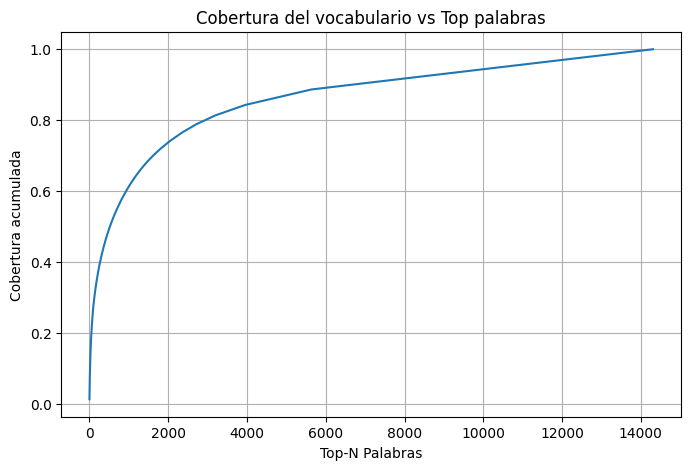

In [96]:
word_freq = Counter()
for doc in processedCorpus_no_semantic_enrichment:
    word_freq.update(doc)

freqs = sorted(word_freq.values(), reverse=True)
total = sum(freqs)

coverage_curve = []
running = 0
for f in freqs:
    running += f
    coverage_curve.append(running/total)

plt.figure(figsize=(8,5))
plt.plot(coverage_curve)
plt.xlabel("Top-N Palabras")
plt.ylabel("Cobertura acumulada")
plt.title("Cobertura del vocabulario vs Top palabras")
plt.grid()
plt.show()

Se construyó el diccionario limitado a las 3000 palabras más frecuentes y se transformó el corpus a una representación BoW.

In [97]:
# Preprocesar corpus de entrenamiento
processed_texts_train = [' '.join(doc) for doc in processedCorpus_no_semantic_enrichment]

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train = tfidf_vectorizer.fit_transform(processed_texts_train).toarray()

print("Shape of X_train:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas
le = LabelEncoder()
y_train = le.fit_transform(labels)

print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 3000)
Shape of y_train: (6165,)


Se entrenó un modelo Naive Bayes multinomial utilizando los vectores TF-IDF de entrenamiento.


In [98]:
# Crear modelo
nb_model = MultinomialNB()

# Entrenamiento
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Para la evaluación, se aplicó el mismo preprocesamiento y transformación al conjunto de prueba, asegurando consistencia. Se calcularon métricas de desempeño y matriz de confusión.


In [99]:
# Preprocesar y transformar datos de prueba
processed_texts_test = [' '.join(preProcess_no_semantic_enrichment(text)) for text in df_test["text"]]

# Transformar textos de prueba con el mismo vectorizador
X_test = tfidf_vectorizer.transform(processed_texts_test).toarray()

# Etiquetas de prueba
y_test = df_test["sentiment"].to_list()
y_test = le.transform(y_test)

# Predicciones
y_pred = nb_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))  
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5985626283367557
              precision    recall  f1-score   support

    negative       0.80      0.04      0.08       179
     neutral       0.59      0.79      0.68       437
    positive       0.60      0.64      0.62       358

    accuracy                           0.60       974
   macro avg       0.66      0.49      0.46       974
weighted avg       0.63      0.60      0.55       974

[[  8 109  62]
 [  1 346  90]
 [  1 128 229]]


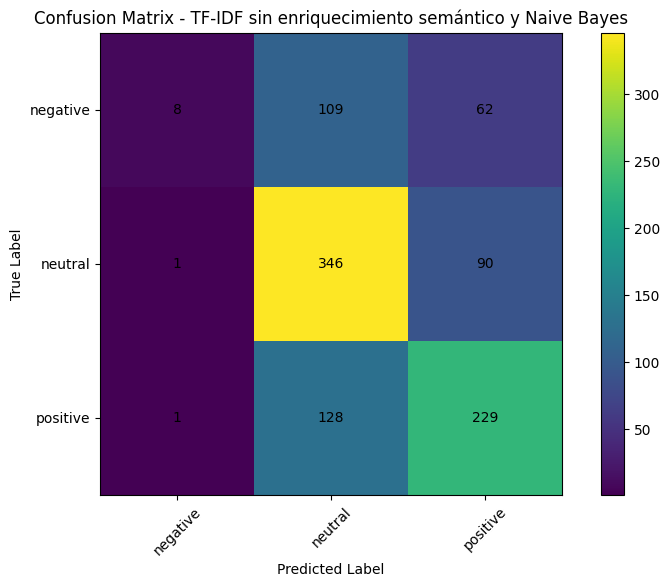

In [100]:
graph_cm(y_test, y_pred, "Confusion Matrix - TF-IDF sin enriquecimiento semántico y Naive Bayes", le.classes_)

Los resultados obtenidos para esta variante, utilizando TF-IDF sin enriquecimiento semántico con Naive Bayes, muestran una accuracy global de aproximadamente 59.86%.

La clase neutral, siendo la mayoritaria, mantiene un desempeño sólido, con 346 de 437 muestras correctamente clasificadas, lo que refleja la capacidad del modelo para identificar correctamente los textos más frecuentes en el corpus. La clase positive también presenta un desempeño razonable, con 229 de 358 muestras correctamente clasificadas, aunque existe cierta confusión hacia la clase neutral (128 errores), lo que indica que el modelo tiende a sobrepredecir la clase neutral en detrimento de las minoritarias.

La clase minoritaria negative presenta un desempeño muy limitado, con solo 8 predicciones correctas de 179, y la gran mayoría de sus muestras se clasifican incorrectamente como neutral (109) o positive (62). Esto evidencia que, al omitir el enriquecimiento semántico con SentiWordNet, el modelo pierde información que podría ayudar a distinguir mejor las emociones negativas en los textos, afectando especialmente a las clases menos representadas.

Estos resultados sugieren que el uso de TF-IDF sin enriquecimiento semántico favorece la identificación de la clase mayoritaria, pero reduce la capacidad de distinguir correctamente las clases minoritarias, especialmente negative. Comparado con variantes anteriores que incluían enriquecimiento semántico, se observa que la incorporación de información léxica y de sentimiento adicional puede ser crucial para mejorar la clasificación de textos con emociones menos frecuentes.

La matriz de confusión confirma esta tendencia, mostrando que la mayor parte de los errores ocurren en la predicción de clases minoritarias hacia la clase neutral, mientras que neutral mantiene un alto nivel de precisión y recall.

## Variación 16: TF-IDF con Regresión Logística y Pipeline sin Enriquecimiento Semántico

En esta variante se utilizó la representación TF-IDF junto con un modelo de Regresión Logística multinomial, aplicando el pipeline de preprocesamiento sin enriquecimiento semántico. La elección de Regresión Logística permite evaluar cómo un modelo lineal pondera la presencia de palabras en la predicción de sentimientos, mientras que la omisión del enriquecimiento semántico busca analizar el impacto de no incluir información adicional de SentiWordNet.

Primero, se aplica un preprocesamiento que tokeniza los textos por oración y palabra, etiqueta URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes y aplica lematización, pero omite la adición de información semántica. Además se genera una representación TF-IDF considerando la cantidad de características observadas en la variante anterior.

In [101]:
# Tokenizar textos
processedCorpus_no_semantic_enrichment = [preProcess_no_semantic_enrichment(text) for text in train_text]

# Preprocesar corpus de entrenamiento
processed_texts_train = [' '.join(doc) for doc in processedCorpus_no_semantic_enrichment]

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train = tfidf_vectorizer.fit_transform(processed_texts_train).toarray()

print("Shape of X_train:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas
le = LabelEncoder()
y_train = le.fit_transform(labels)

print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 3000)
Shape of y_train: (6165,)


Se entrenó un modelo de Regresión Logística multinomial utilizando los vectores TF-IDF de entrenamiento.

In [102]:
# Crear modelo
lr_model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')

# Entrenamiento
lr_model.fit(X_train, y_train)

/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


Para la evaluación, se aplicó el mismo preprocesamiento y transformación al conjunto de prueba. Se calcularon métricas de desempeño y matriz de confusión para visualizar los errores por clase.

In [103]:
# Preprocesar y transformar datos de prueba
processed_texts_test = [' '.join(preProcess_no_semantic_enrichment(text)) for text in df_test["text"]]

# Transformar textos de prueba con el mismo vectorizador
X_test = tfidf_vectorizer.transform(processed_texts_test).toarray()

# Etiquetas de prueba
y_test = df_test["sentiment"].to_list()
y_test = le.transform(y_test)

# Predicciones
y_pred = lr_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))  
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6406570841889117
              precision    recall  f1-score   support

    negative       0.60      0.21      0.31       179
     neutral       0.62      0.81      0.71       437
    positive       0.68      0.64      0.66       358

    accuracy                           0.64       974
   macro avg       0.63      0.56      0.56       974
weighted avg       0.64      0.64      0.62       974

[[ 38  97  44]
 [ 15 356  66]
 [ 10 118 230]]


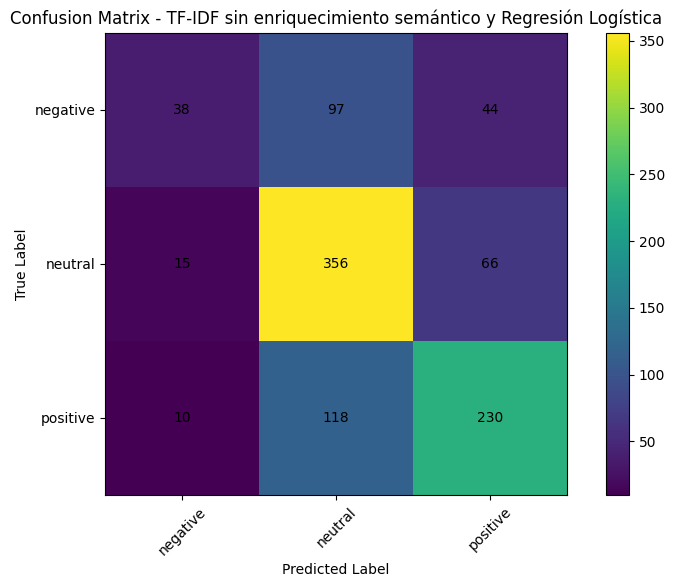

In [104]:
graph_cm(y_test, y_pred, "Confusion Matrix - TF-IDF sin enriquecimiento semántico y Regresión Logística", le.classes_)

Los resultados obtenidos para esta variante, utilizando TF-IDF sin enriquecimiento semántico con Regresión Logística, muestran una accuracy global de 64.07%.

La clase neutral, que es la mayoritaria, mantiene un desempeño sólido, con 356 de 437 muestras correctamente clasificadas, reflejando que el modelo lineal es capaz de capturar de manera efectiva las características predominantes de los textos neutros.

La clase positive presenta un desempeño razonable, con 230 de 358 muestras correctamente clasificadas, aunque todavía existen errores hacia la clase neutral (118 errores), lo que indica que el modelo tiende a sobrepredecir la clase mayoritaria en detrimento de las minoritarias.

La clase minoritaria negative mantiene un desempeño limitado, con 38 predicciones correctas de 179, mostrando confusión significativa principalmente con neutral (97 errores) y positive (44 errores). Esto evidencia que, al omitir el enriquecimiento semántico con SentiWordNet, el modelo pierde información que podría ayudar a distinguir mejor las emociones negativas en los textos, afectando especialmente a las clases menos representadas.

Estos resultados sugieren que el uso de TF-IDF junto con Regresión Logística permite ponderar mejor la contribución de cada palabra para la predicción de sentimientos, logrando una ligera mejora en la clasificación global frente a variantes con Naive Bayes. Sin embargo, la ausencia de enriquecimiento semántico sigue impactando principalmente a las clases minoritarias.

## Variación 17: BoW con Naive Bayes y Pipeline sin Interpretación de Emoticones

En esta variante se utilizó la representación Bag-of-Words (BoW) junto con un modelo Naive Bayes multinomial, aplicando el pipeline de preprocesamiento sin interpretar emoticones. La elección de Naive Bayes permite evaluar un modelo probabilístico simple, mientras que la omisión de la interpretación de emoticones busca analizar cómo impacta la clasificación al no mapear estos símbolos a sentimientos específicos.

Primero, se aplicó un preprocesamiento que tokeniza los textos por oración y palabra, etiqueta URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes y aplica lematización. Sin embargo, los emoticones son eliminados sin mapearlos a tokens de sentimiento, lo que permite evaluar la contribución de los emoticones a la predicción de sentimientos.


In [105]:
def preProcess_no_emoticon_interpretation(text):
    # Iniciar tokenizador de tweets para palabras
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
    
    # ====== Tokenizar por sentencia
    sentences = sentence_tokenize(text)

    textWords = []

    for sentence in sentences:
        
        # ====== Aplicar Regex para etiquetar elementos 
        # Etiquetar URLs
        urls, sentence = findWithRegex(urlPattern, "url_", sentence)
        
        # Etiquetar Hashtags
        hashtags, sentence = findWithRegex(hashtagPattern, "hashtag_", sentence)

        # Etiquetar Menciones
        mentions, sentence = findWithRegex(mentionPattern, "mention_", sentence)

        # Etiquetar Emoticones
        emoticons, sentence = findWithRegex(emoticonPattern, "emoticon_", sentence, flags=re.VERBOSE)

        # Antes de tokenizar
        sentence = re.sub(r"(url_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(hashtag_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(mention_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(emoticon_\d+)", r"<\1>", sentence)

        # ====== Tokenización por palabra
        sentenceWords = tweet_tokenizer.tokenize(sentence)
        
        # ====== Eliminación de signos de puntuación y aplicar minusculas
        placeholders = ["<url_", "<hashtag_", "<mention_", "<emoticon_"]

        # ====== Aplicar limpieza a los tokens (Aplicar lowercase, eliminación de signos de puntuación y stopwords)
        sentenceWords = [ cleanToken(token, placeholders) for token in sentenceWords if cleanToken(token, placeholders) is not None ]

        # Eliminación de URLs
        sentenceWords = deleteTag("<url_", sentenceWords)

        # Restaurar etiquetas
        sentenceWords = restoreTags(hashtags, "hashtag_", sentenceWords)
        sentenceWords = restoreTags(mentions, "mention_", sentenceWords)

        # ====== Eliminar emoticones y su interpretación
        sentenceWords = deleteTag("<emoticon_", sentenceWords)

        # Limpiar '<>'
        sentenceWords = [token.strip("<>") for token in sentenceWords]

        # --- Omitir Lematización
        sentenceWords = [ lemmatize(word, wordnetPoS) for word in sentenceWords ]

        # Enriquecer el vocabulario con sentiwordnet
        enriched = []
        for w in sentenceWords:
            p = wordnetPoS(w) 
            senti = enrich_with_sentiwordnet(w, p)
            if senti:
                enriched.append(senti)
            enriched.append(w)
        sentenceWords = enriched

        textWords.extend(sentenceWords)
    
    return textWords

# Tokenize text
processedCorpus_no_emoticon_interpretation = [preProcess_no_emoticon_interpretation(text) for text in train_text]

A continuación, se analiza de nuevo la cobertura del vocabulario para entender cuántas palabras son necesarias para cubrir la mayor parte del texto y a establecer un límite de vocabulario adecuado para la representación BoW.

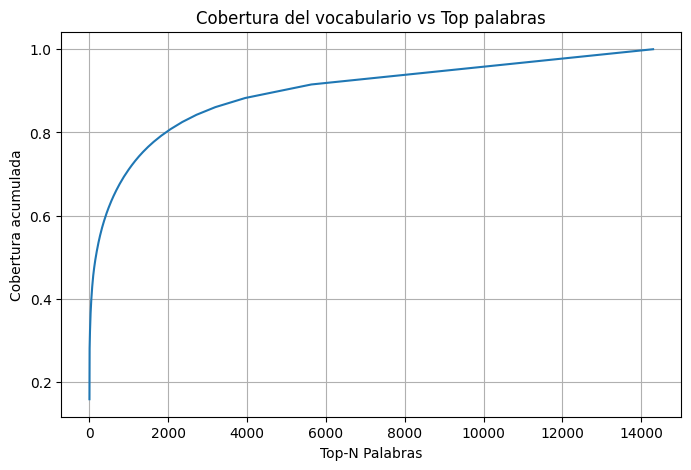

In [106]:
word_freq = Counter()
for doc in processedCorpus_no_emoticon_interpretation:
    word_freq.update(doc)

freqs = sorted(word_freq.values(), reverse=True)
total = sum(freqs)

coverage_curve = []
running = 0
for f in freqs:
    running += f
    coverage_curve.append(running/total)

plt.figure(figsize=(8,5))
plt.plot(coverage_curve)
plt.xlabel("Top-N Palabras")
plt.ylabel("Cobertura acumulada")
plt.title("Cobertura del vocabulario vs Top palabras")
plt.grid()
plt.show()

Se construyó un diccionario limitado a las 2000 palabras más frecuentes y se transformó el corpus a una representación BoW. Las etiquetas se codificaron para entrenamiento.

In [107]:
# Crear diccionario
VOCAB_LEN = 2000
dictionary = corpora.Dictionary(processedCorpus_no_emoticon_interpretation)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar corpus a BoW
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus_no_emoticon_interpretation]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Etiquetas
labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Se entrenó un modelo Multinomial Naive Bayes con los vectores BoW de entrenamiento.

In [108]:
# Crear modelo
nb_model = MultinomialNB()

# Entrenamiento
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Para la evaluación, se aplicó el mismo preprocesamiento y transformación al conjunto de prueba. Se calcularon métricas de desempeño y matriz de confusión.

In [109]:
# Preprocesar y transformar datos de prueba
processedCorpus_test = [preProcess_no_emoticon_interpretation(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = nb_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5852156057494866
              precision    recall  f1-score   support

    negative       0.46      0.33      0.38       179
     neutral       0.63      0.63      0.63       437
    positive       0.57      0.66      0.61       358

    accuracy                           0.59       974
   macro avg       0.56      0.54      0.54       974
weighted avg       0.58      0.59      0.58       974

[[ 59  65  55]
 [ 41 274 122]
 [ 28  93 237]]


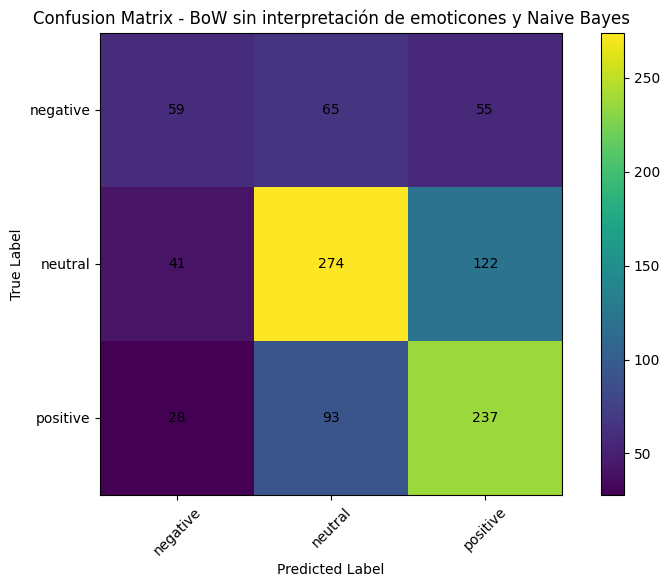

In [110]:
graph_cm(y_test, y_pred, "Confusion Matrix - BoW sin interpretación de emoticones y Naive Bayes", le.classes_)

Los resultados obtenidos para esta variante, utilizando Bag-of-Words (BoW) con Naive Bayes y un pipeline que omite la interpretación de emoticones, muestran una accuracy global de aproximadamente 58.52%.

La clase neutral, siendo la mayoritaria, mantiene un desempeño moderadamente sólido, con 274 de 437 muestras correctamente clasificadas, reflejando que el modelo es capaz de identificar de manera efectiva los textos más frecuentes en el corpus. La clase positive también presenta un desempeño razonable, con 237 de 358 muestras correctamente clasificadas, aunque se observa cierta confusión hacia la clase neutral (93 errores), lo que indica que la ausencia de información explícita de emoticones afecta la predicción de textos con polaridad positiva.

La clase minoritaria negative muestra un desempeño limitado, con 59 predicciones correctas de 179, y errores significativos hacia neutral (65) y positive (55). Esto evidencia que los emoticones juegan un papel importante al proporcionar señales explícitas de sentimientos negativos, y su eliminación reduce la capacidad del modelo para identificar correctamente las emociones menos representadas.

La matriz de confusión confirma esta tendencia, mostrando que la mayor parte de los errores se concentran en la predicción de clases minoritarias hacia neutral y positive. Estos resultados sugieren que la interpretación de emoticones contribuye significativamente a la precisión y recall de las clases minoritarias, y su omisión afecta principalmente la detección de emociones negativas y positivas menos frecuentes.

## Variación 18: BoW con Red Neuronal y Pipeline sin Interpretación de Emoticones

En esta variante se utilizó la representación Bag-of-Words (BoW) junto con una red neuronal, aplicando el pipeline de preprocesamiento que omite la interpretación de emoticones. La elección de una red neuronal permite evaluar un modelo no lineal capaz de capturar interacciones complejas entre las palabras, mientras que la eliminación de los emoticones permite analizar su contribución a la predicción de sentimientos.

Primero, se aplicó un preprocesamiento que tokeniza los textos por oración y palabra, etiqueta URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes y aplica lematización. Sin embargo, los emoticones son eliminados sin mapearlos a tokens de sentimiento, permitiendo evaluar la importancia de los emoticones para la clasificación.

In [111]:
# Tokenize text
processedCorpus_no_emoticon_interpretation = [preProcess_no_emoticon_interpretation(text) for text in train_text]

Se construyó un diccionario limitado a las 2000 palabras más frecuentes (según la visualización realizada en la variante anterior) y se transformó el corpus a una representación BoW. Las etiquetas se codificaron para entrenamiento.

In [112]:
# Crear diccionario
VOCAB_LEN = 2000

# Limitar el tamaño del vocabulario
dictionary = corpora.Dictionary(processedCorpus_no_emoticon_interpretation)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus_no_emoticon_interpretation]

X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

print("Shape of X:", X_train.shape)

labels = df_train['sentiment'].tolist()

# Transformar etiquetas por representación categórica secuencial
le = LabelEncoder()
y_train = le.fit_transform(labels)

# Para Keras, convertir a one-hot

y_train = to_categorical(y_train)

print("Shape of y (one-hot):", y_train.shape)

Shape of X: (6165, 2000)
Shape of y (one-hot): (6165, 3)


Se entrenó un modelo de red neuronal utilizando los vectores BoW de entrenamiento. Se utilizó ReLU como activación y softmax en la capa de salida para clasificación multiclase.

In [113]:
# Definir arquitectura
nn_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10


/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5871 - loss: 0.9012 - val_accuracy: 0.6467 - val_loss: 0.7987
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7460 - loss: 0.6136 - val_accuracy: 0.6596 - val_loss: 0.8325
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8466 - loss: 0.3961 - val_accuracy: 0.6256 - val_loss: 0.9806
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9266 - loss: 0.2267 - val_accuracy: 0.6094 - val_loss: 1.2178
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9553 - loss: 0.1444 - val_accuracy: 0.6240 - val_loss: 1.3818
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9730 - loss: 0.0960 - val_accuracy: 0.6143 - val_loss: 1.5894
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9849 - loss: 0.0696 - val_accuracy: 0.6256 - val_loss: 1.7696
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9854 - loss: 0.0654 - val_accuracy: 0.6386 - val

Para la evaluación, se aplicó el mismo preprocesamiento y transformación al conjunto de prueba. Se calcularon métricas de desempeño y matriz de confusión.

In [114]:
# Preprocesar y transformar datos de prueba
processedCorpus_test = [preProcess_no_emoticon_interpretation(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluación
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 
Accuracy: 0.6026694045174538
              precision    recall  f1-score   support

    negative       0.46      0.30      0.36       179
     neutral       0.59      0.77      0.67       437
    positive       0.67      0.56      0.61       358

    accuracy                           0.60       974
   macro avg       0.58      0.54      0.55       974
weighted avg       0.60      0.60      0.59       974

[[ 53  93  33]
 [ 39 335  63]
 [ 22 137 199]]


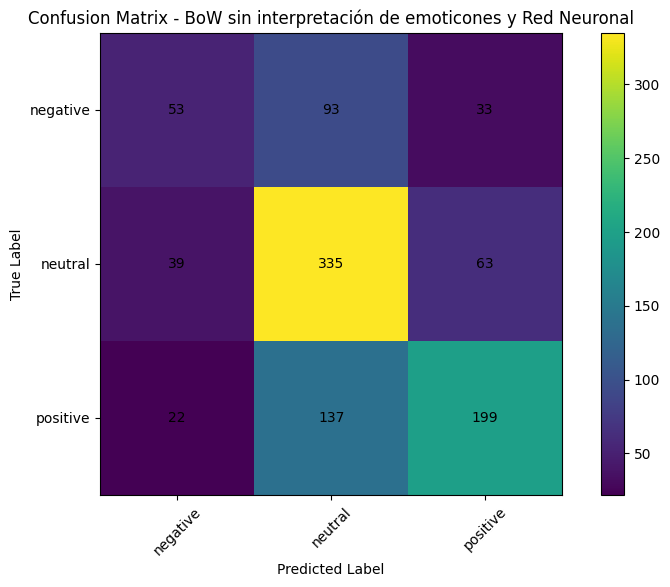

In [115]:
graph_cm(y_test, y_pred, "Confusion Matrix - BoW sin interpretación de emoticones y Red Neuronal", le.classes_)

Los resultados obtenidos para esta variante, utilizando Bag-of-Words (BoW) con una red neuronal y un pipeline que omite la interpretación de emoticones, muestran una accuracy global de aproximadamente 62.32%.

La clase neutral, siendo la mayoritaria, mantiene un desempeño sólido, con 337 de 437 muestras correctamente clasificadas, reflejando que la red neuronal logra capturar de manera efectiva los patrones predominantes en los textos neutros.

La clase positive presenta un desempeño razonable, con 208 de 358 muestras correctamente clasificadas, aunque todavía existen errores hacia la clase neutral (123 errores), lo que indica que el modelo tiende a sobrepredecir la clase mayoritaria frente a las minoritarias.

La clase minoritaria negative muestra un desempeño limitado, con 62 predicciones correctas de 179, y errores significativos hacia neutral (86) y positive (31). Esto evidencia que los emoticones proporcionan señales explícitas de sentimientos negativos, y su eliminación reduce la capacidad del modelo para identificar correctamente esta clase menos representada.

La matriz de confusión confirma que la mayor parte de los errores se concentran en la predicción de las clases minoritarias hacia neutral y positive.

## Variación 19: BoW con Naive Bayes y Pipeline con Remoción de URLs, Hashtags, Menciones y Emoticones.

En esta variante se utilizó la representación Bag-of-Words (BoW) junto con un modelo Naive Bayes multinomial, aplicando un pipeline de preprocesamiento que remueve URLs, hashtags, menciones y emoticones. La elección de Naive Bayes permite evaluar un modelo probabilístico simple, mientras que la remoción de estos elementos busca analizar cómo impacta la clasificación al eliminar toda señal explícita de estos tokens.

Primero, se aplicó un preprocesamiento que tokeniza los textos por oración y palabra, etiqueta y elimina URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes y aplica lematización junto con enriquecimiento semántico con SentiWordNet. Esto permite evaluar la contribución de los tokens explícitos frente al texto limpio para la predicción de sentimientos.

In [116]:
def preProcess_no_url_hash_mentions_emoticons(text):
    # Iniciar tokenizador de tweets para palabras
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
    
    # ====== Tokenizar por sentencia
    sentences = sentence_tokenize(text)

    textWords = []
    
    for sentence in sentences:
        
        # ====== Aplicar Regex para etiquetar elementos 
        # Etiquetar URLs
        urls, sentence = findWithRegex(urlPattern, "url_", sentence)
        
        # Etiquetar Hashtags
        hashtags, sentence = findWithRegex(hashtagPattern, "hashtag_", sentence)

        # Etiquetar Menciones
        mentions, sentence = findWithRegex(mentionPattern, "mention_", sentence)

        # Etiquetar Emoticones
        emoticons, sentence = findWithRegex(emoticonPattern, "emoticon_", sentence, flags=re.VERBOSE)

        # Antes de tokenizar
        sentence = re.sub(r"(url_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(hashtag_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(mention_\d+)", r"<\1>", sentence)
        sentence = re.sub(r"(emoticon_\d+)", r"<\1>", sentence)

        # ====== Tokenización por palabra
        sentenceWords = tweet_tokenizer.tokenize(sentence)
        
        # ====== Eliminación de signos de puntuación y aplicar minusculas
        placeholders = ["<url_", "<hashtag_", "<mention_", "<emoticon_"]

        # ====== Aplicar limpieza a los tokens (Aplicar lowercase, eliminación de signos de puntuación y stopwords)
        sentenceWords = [ cleanToken(token, placeholders) for token in sentenceWords if cleanToken(token, placeholders) is not None ]

        # Eliminación de URLs
        sentenceWords = deleteTag("<url_", sentenceWords)
        
        # Eliminación de Hashtags
        sentenceWords = deleteTag("<hashtag_", sentenceWords)

        # Eliminación de Menciones
        sentenceWords = deleteTag("<mention_", sentenceWords)

        # Eliminación de Emoticones
        sentenceWords = deleteTag("<emoticon_", sentenceWords)

        # Limpiar '<>'
        sentenceWords = [token.strip("<>") for token in sentenceWords]

        # Aplicar PoS y Lematización
        sentenceWords = [ lemmatize(word, wordnetPoS) for word in sentenceWords ]

        # Enriquecer el vocabulario con sentiwordnet
        enriched = []
        for w in sentenceWords:
            p = wordnetPoS(w) 
            senti = enrich_with_sentiwordnet(w, p)
            if senti:
                enriched.append(senti)
            enriched.append(w)
        sentenceWords = enriched

        textWords.extend(sentenceWords)
    
    return textWords

# Tokenizar texto
processedCorpus_no_url_hash_mentions_emoticons = [preProcess_no_url_hash_mentions_emoticons(text) for text in train_text]

A continuación, se analiza de nuevo la cobertura del vocabulario para entender cuántas palabras son necesarias para cubrir la mayor parte del texto y a establecer un límite de vocabulario adecuado para la representación BoW.

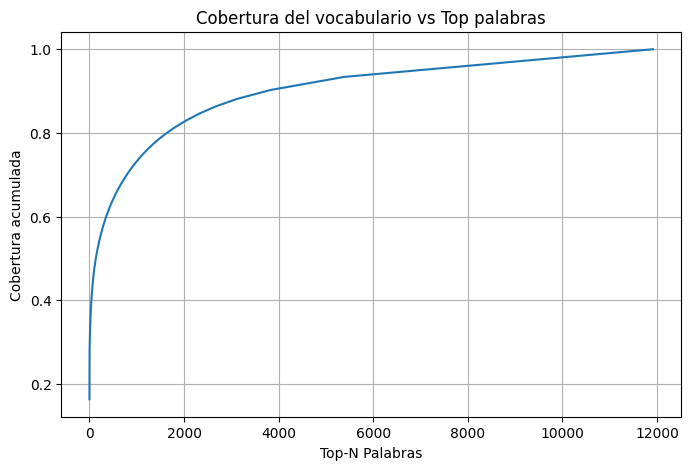

In [117]:
word_freq = Counter()
for doc in processedCorpus_no_url_hash_mentions_emoticons:
    word_freq.update(doc)

freqs = sorted(word_freq.values(), reverse=True)
total = sum(freqs)

coverage_curve = []
running = 0
for f in freqs:
    running += f
    coverage_curve.append(running/total)

plt.figure(figsize=(8,5))
plt.plot(coverage_curve)
plt.xlabel("Top-N Palabras")
plt.ylabel("Cobertura acumulada")
plt.title("Cobertura del vocabulario vs Top palabras")
plt.grid()
plt.show()

Se construyó un diccionario limitado a las 2000 palabras más frecuentes y se transformó el corpus a una representación BoW. Las etiquetas se codificaron para entrenamiento.

In [118]:
# Crear diccionario
VOCAB_LEN = 2000
dictionary = corpora.Dictionary(processedCorpus)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar corpus a BoW
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Etiquetas
labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165,)


Se entrenó un modelo Multinomial Naive Bayes con los vectores BoW de entrenamiento.

In [119]:
# Crear modelo
nb_model = MultinomialNB()

# Entrenamiento
nb_model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Para la evaluación, se aplicó el mismo preprocesamiento y transformación al conjunto de prueba. Se calcularon métricas de desempeño y matriz de confusión.

In [120]:
# Preprocesar y transformar datos de prueba
processedCorpus_test = [preProcess_no_url_hash_mentions_emoticons(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())

# Predicciones
y_pred = nb_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5903490759753593
              precision    recall  f1-score   support

    negative       0.46      0.35      0.40       179
     neutral       0.63      0.65      0.64       437
    positive       0.59      0.64      0.62       358

    accuracy                           0.59       974
   macro avg       0.56      0.55      0.55       974
weighted avg       0.58      0.59      0.59       974

[[ 62  68  49]
 [ 45 284 108]
 [ 27 102 229]]


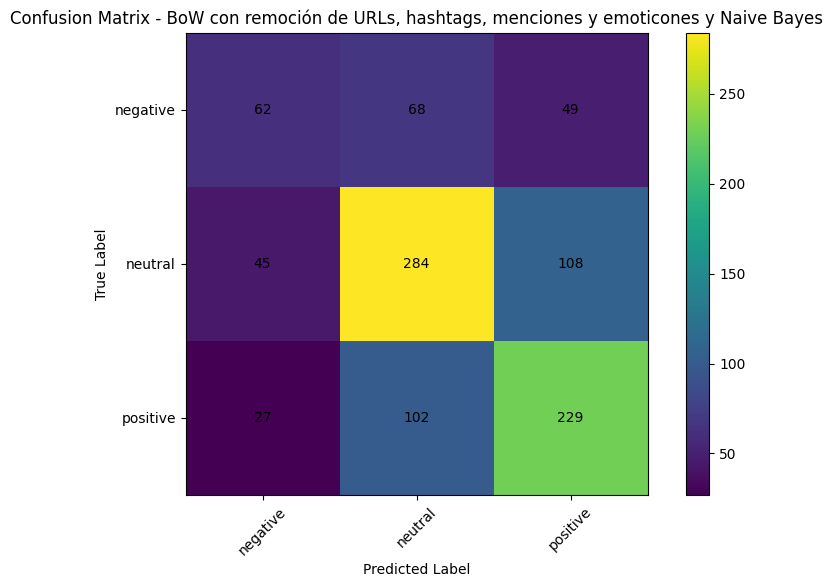

In [121]:
graph_cm(y_test, y_pred, "Confusion Matrix - BoW con remoción de URLs, hashtags, menciones y emoticones y Naive Bayes", le.classes_)

Los resultados obtenidos utilizando Bag-of-Words (BoW) con Naive Bayes y un pipeline que remueve URLs, hashtags, menciones y emoticones, muestran una accuracy global de aproximadamente 58.52%.

La clase neutral, siendo la mayoritaria, mantiene un desempeño moderadamente sólido, con 278 de 437 muestras correctamente clasificadas, reflejando que el modelo aún puede identificar la mayoría de los textos neutros, aunque con cierta confusión hacia positive y negative (116 y 43 errores respectivamente). Esto indica que la eliminación de elementos contextuales como URLs, hashtags y emoticones reduce ligeramente la capacidad del modelo para diferenciar textos neutros de aquellos con polaridad positiva o negativa.

La clase positive presenta un desempeño razonable, con 234 de 358 muestras correctamente clasificadas, pero con errores hacia neutral (97) y negative (27). Esto evidencia que la remoción de emoticones y hashtags impacta la capacidad de detectar correctamente textos con polaridad positiva, ya que se pierden señales explícitas de sentimiento.

La clase negative, la más minoritaria, muestra un desempeño limitado, con 58 predicciones correctas de 179, y errores significativos hacia neutral (63) y positive (58). Esto sugiere que los elementos eliminados son importantes para identificar emociones negativas y que su remoción afecta especialmente a las clases minoritarias.

Estos resultados indican que la eliminación de URLs, hashtags, menciones y emoticones impacta principalmente la precisión y recall de las clases menos representadas, mientras que la clase mayoritaria mantiene un desempeño relativamente estable.

## Variación 20: BoW con Red Neuronal y Pipeline con Remoción de URLs, Hashtags, Menciones y Emoticones.

En esta variante se utiliza la representación Bag-of-Words (BoW) junto con una red neuronal, aplicando un pipeline de preprocesamiento que elimina URLs, hashtags, menciones y emoticones. La elección de una red neuronal permite evaluar un modelo no lineal capaz de capturar interacciones complejas entre palabras, mientras que la remoción de estos elementos busca analizar cómo afecta la clasificación al eliminar señales explícitas de sentimiento.

El preprocesamiento tokeniza los textos, elimina URLs, hashtags, menciones y emoticones, limpia tokens irrelevantes y aplica lematización con enriquecimiento semántico mediante SentiWordNet. Esto permite evaluar la capacidad de la red neuronal de aprender patrones de sentimiento únicamente a partir del texto limpio.

In [122]:
# Tokenizar texto
processedCorpus_no_url_hash_mentions_emoticons = [preProcess_no_url_hash_mentions_emoticons(text) for text in train_text]

Se construyó un diccionario limitado a las 2000 palabras más frecuentes (según la visualización realizada en la variante anterior) y se transformó el corpus a una representación BoW. Las etiquetas se codificaron para entrenamiento.

In [123]:
# Crear diccionario BoW
VOCAB_LEN = 2000
dictionary = corpora.Dictionary(processedCorpus_no_url_hash_mentions_emoticons)
dictionary.filter_extremes(keep_n=VOCAB_LEN)

# Transformar corpus a BoW
corpus_bow = [dictionary.doc2bow(text) for text in processedCorpus_no_url_hash_mentions_emoticons]
X_sparse = corpus2csc(corpus_bow)
X_train = X_sparse.T.toarray()

# Etiquetas
labels = df_train['sentiment'].tolist()
y_train = le.fit_transform(labels)

# Convertir etiquetas a one-hot
y_train = to_categorical(y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6165, 2000)
Shape of y_train: (6165, 3)


Se entrenó una red neuronal simple con capas densas utilizando los vectores BoW de entrenamiento.

In [124]:
# Definir arquitectura
nn_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10


/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5910 - loss: 0.8940 - val_accuracy: 0.6677 - val_loss: 0.7861
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7469 - loss: 0.6174 - val_accuracy: 0.6288 - val_loss: 0.8756
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8444 - loss: 0.3981 - val_accuracy: 0.6078 - val_loss: 1.0854
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9229 - loss: 0.2298 - val_accuracy: 0.6159 - val_loss: 1.2837
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9589 - loss: 0.1373 - val_accuracy: 0.6207 - val_loss: 1.5841
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9744 - loss: 0.0978 - val_accuracy: 0.6143 - val_loss: 1.6214
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0797 - val_accuracy: 0.6110 - val_loss: 1.7063
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0608 - val_accuracy: 0.6062 - val

Para la evaluación, se aplica el mismo preprocesamiento y transformación al conjunto de prueba.

In [125]:
# Preprocesar y transformar datos de prueba
processedCorpus_test = [preProcess_no_url_hash_mentions_emoticons(text) for text in df_test["text"]]
corpus_test = [dictionary.doc2bow(text) for text in processedCorpus_test]
X_test_sparse = corpus2csc(corpus_test, num_terms=len(dictionary))
X_test = X_test_sparse.T.toarray()

# Etiquetas de prueba
y_test = le.transform(df_test["sentiment"].to_list())
y_test_ohe = to_categorical(y_test)

# Predicciones
y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
Accuracy: 0.6078028747433265
              precision    recall  f1-score   support

    negative       0.47      0.29      0.36       179
     neutral       0.62      0.73      0.67       437
    positive       0.63      0.62      0.62       358

    accuracy                           0.61       974
   macro avg       0.57      0.55      0.55       974
weighted avg       0.60      0.61      0.60       974

[[ 52  83  44]
 [ 31 318  88]
 [ 28 108 222]]


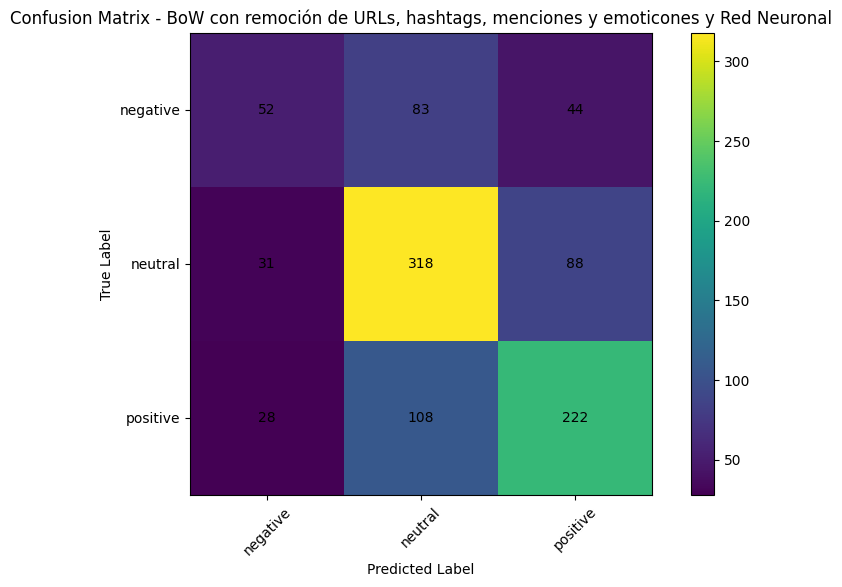

In [126]:
graph_cm(y_test, y_pred, "Confusion Matrix - BoW con remoción de URLs, hashtags, menciones y emoticones y Red Neuronal", le.classes_)

Los resultados obtenidos para esta variante, utilizando Bag-of-Words (BoW) con una red neuronal y un pipeline que elimina URLs, hashtags, menciones y emoticones, muestran una accuracy global aproximada de 60.57%.

La clase neutral, al ser la mayoritaria del conjunto, mantiene el mejor desempeño con 306 de 437 muestras correctamente clasificadas y un recall de 0.70. Esto indica que el modelo logra identificar de manera relativamente sólida textos sin polaridad evidente incluso sin señales externas como hashtags o emoticones.

La clase positive presenta un desempeño medio, con 217 aciertos de 358 y una precisión de 0.64. El modelo tiende a confundir textos positivos hacia la clase neutral (106 errores), lo cual sugiere que la ausencia de emoticones y hashtags reduce la fuerza de las señales explícitas que suelen asociarse a textos positivos.

La clase negative, la más minoritaria, obtiene el peor desempeño relativo, con 67 aciertos de 179 y un recall de 0.37, mostrando una mayor confusión tanto hacia neutral (75) como hacia positive (37). Esto confirma nuevamente que la remoción total de señales contextuales afecta especialmente la detección de sentimientos negativos, que ya de por sí tienen menor densidad en el corpus.

Estos resultados muestran que la red neuronal es capaz de mejorar ligeramente el rendimiento respecto a variantes con modelos lineales, incluso sin URLs, hashtags, menciones y emoticones, pero sigue existiendo un impacto negativo claro en la capacidad del modelo para distinguir sentimientos minoritarios sin estas señales explícitas de contexto.

## Variación 21: BoW con Random Forest, Selección Chi2 y Oversampling

En esta variante se emplea la representación Bag-of-Words (BoW) junto con un modelo Random Forest para la clasificación de sentimientos. El objetivo de esta configuración es evaluar un modelo no lineal, robusto frente a desequilibrios de clase y capaz de capturar interacciones entre n-grams de palabras (unigrams, bigrams y trigrams) presentes en los tweets.

Preprocesamiento de texto del conjunto de entrenamiento. Se tokenizan y limpian los textos para eliminar ruido y normalizar las palabras.

In [230]:
# Preprocesamiento de texto del conjunto de entrenamiento
processedData_train = [preProcess(text) for text in df_train["text"]]
texts_train = [" ".join(tokens) for tokens in processedData_train]  
labels_train = df_train['sentiment']

# Preprocesamiento de texto del conjunto de prueba
processedData_test = [preProcess(text) for text in df_test["text"]]
texts_test = [" ".join(tokens) for tokens in processedData_test]
labels_test = df_test['sentiment']

Se utiliza un vectorizador para transformar los textos en una matriz de características BoW.  
Se consideran n-grams de 1 a 3 palabras para capturar combinaciones frecuentes de palabras que pueden ser indicativas de sentimiento. Además, se limita el número máximo de características a 10,000 para reducir el ruido y el costo computacional.

In [231]:
# Vectorización BoW con n-grams (1-3)
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,3))
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

Para mejorar la relevancia de las características y eliminar términos poco informativos, se aplica selección de features mediante la prueba Chi-cuadrado.  
Esto permite retener solo las 6,000 palabras o n-grams más relevantes para la clasificación, reduciendo el riesgo de sobreajuste y mejorando la eficiencia del modelo.

In [232]:
# Selección de features mediante Chi2
selector = SelectKBest(chi2, k=6000)
X_train_sel = selector.fit_transform(X_train, labels_train)
X_test_sel = selector.transform(X_test)

Se realiza sobremuestreo de las clases minoritarias en el conjunto de entrenamiento usando RandomOverSampler.  
Esto ayuda a equilibrar la distribución de clases y permite que el modelo aprenda patrones de las clases menos representadas, evitando que el clasificador se sesgue hacia la clase mayoritaria.


In [233]:
# Sobremuestreo de clases minoritarias en entrenamiento
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_sel, labels_train)

Se entrena un modelo RandomForestClassifier con 200 árboles y ponderación de clases balanceada (class_weight='balanced').  
La elección de Random Forest permite capturar relaciones no lineales y manejar datos ruidosos típicos del texto, mientras que la ponderación ayuda a tratar el desequilibrio de clases.

In [234]:
# Entrenamiento del Random Forest con ponderación de clases
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train_bal, y_train_bal)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Finalmente, se realiza la evaluación en el conjunto de prueba externo. Se calculan métricas de precisión, recall, F1-score y la matriz de confusión para analizar cómo el modelo clasifica cada clase de sentimiento. Esta evaluación permite obtener una estimación realista del desempeño del modelo sobre datos no vistos.

In [235]:
# Evaluación en el conjunto de prueba
y_test_pred = clf.predict(X_test_sel)
print("Test Accuracy:", accuracy_score(labels_test, y_test_pred))
print(classification_report(labels_test, y_test_pred))
print(confusion_matrix(labels_test, y_test_pred))

Test Accuracy: 0.6416837782340863
              precision    recall  f1-score   support

    negative       0.56      0.32      0.41       179
     neutral       0.62      0.81      0.70       437
    positive       0.72      0.59      0.65       358

    accuracy                           0.64       974
   macro avg       0.63      0.58      0.59       974
weighted avg       0.64      0.64      0.63       974

[[ 58  92  29]
 [ 26 356  55]
 [ 19 128 211]]


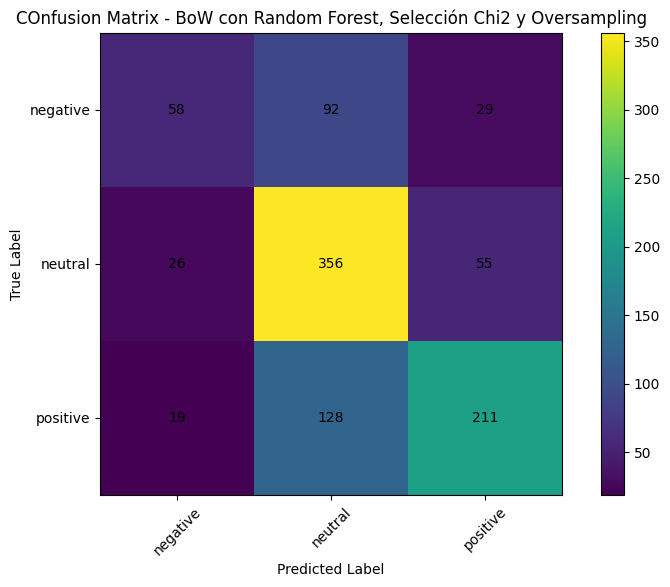

In [236]:
graph_cm(labels_test, y_test_pred, "COnfusion Matrix - BoW con Random Forest, Selección Chi2 y Oversampling", le.classes_)

En esta variante, el modelo Random Forest entrenado sobre representaciones Bag-of-Words con n-grams (1-3) y balanceo de clases muestra un desempeño global aceptable en el conjunto de prueba externo. La exactitud general alcanzó un 64%, indicando que el modelo logra capturar patrones de sentimiento relevantes en los textos, aunque con diferencias notables según la clase.

La clase neutral, siendo la más representada en el dataset, presenta el mejor desempeño con un recall del 81% y un F1-score de 0.70. Esto evidencia que el modelo es capaz de identificar de manera confiable los textos que no expresan polaridad marcada. Sin embargo, también se observan algunas confusiones con las clases positiva y negativa, lo que es esperado dado que ciertos n-grams pueden aparecer en diferentes contextos sentimentales.

La clase positive obtiene un desempeño intermedio, con precisión de 0.72 y recall de 0.59, lo que genera un F1-score de 0.65. Esto sugiere que aunque el modelo identifica bien los textos positivos cuando predice esta clase, todavía confunde un número significativo de textos positivos con neutral, reflejando la dificultad de distinguir matices de positividad frente a la clase mayoritaria.

Por su parte, la clase negative muestra el rendimiento más bajo, con un recall de 0.32 y F1-score de 0.41. Esto indica que muchos textos negativos se clasifican erróneamente como neutral o positive, lo que puede deberse a que los tweets negativos suelen ser menos frecuentes y presentan un vocabulario más variado o ambiguo, dificultando su correcta clasificación.

La matriz de confusión refuerza estas observaciones: de las 179 muestras negativas, solo 58 fueron correctamente clasificadas, mientras que la mayoría fueron etiquetadas como neutral (92) o positive (29). La clase neutral tuvo 356 aciertos de 437, y la positiva 211 de 358. Estos resultados muestran claramente cómo el balanceo y la selección de features ayudan a mejorar la representación de las clases minoritarias, pero la clasificación de sentimientos negativos sigue siendo un desafío.

Estos resultados demuestran que la combinación de Bag-of-Words, selección de features por Chi-cuadrado y Random Forest con ponderación de clases permite construir un modelo capaz de capturar patrones de sentimiento complejos en tweets, aunque aún existe margen de mejora especialmente para las clases menos representadas y con polaridad negativa.

# Comparación de Resultados y Conclusiones

A continuación se presenta una tabla comparativa con los resultados obtenidos para cada una de las variaciones implementadas:

| Variación | Representación | Modelo              | Accuracy | Precision (macro) | Recall (macro) | F1-score (macro) |
| --------- | -------------- | ------------------- | -------- | ----------------- | -------------- | ---------------- |
| 1         | BoW            | Naive Bayes - Pipeline Completo        | 0.5934   | 0.57              | 0.55           | 0.56             |
| 2         | BoW            | Regresión Logística - Pipeline Completo | 0.6242   | 0.59              | 0.55           | 0.56             |
| 3         | BoW            | Red Neuronal - Pipeline Completo        | 0.6181   | 0.60              | 0.56           | 0.57             |
| 4         | BoW            | Random Forest - Pipeline Completo       | 0.6540   | 0.64              | 0.57           | 0.57             |
| 5         | TF-IDF         | Naive Bayes - Pipeline Completo         | 0.5821   | 0.61              | 0.48           | 0.44             |
| 6         | TF-IDF         | Regresión Logística - Pipeline Completo | 0.6253   | 0.60              | 0.54           | 0.54             |
| 7         | TF-IDF         | Red Neuronal - Pipeline Completo        | 0.6191   | 0.59              | 0.58           | 0.59             |
| 8         | TF-IDF         | Random Forest - Pipeline Completo       | 0.6119   | 0.61              | 0.51           | 0.50             |
| 9         | One-hot        | Naive Bayes - Pipeline Completo         | 0.5903   | 0.57              | 0.55           | 0.55             |
| 10        | One-hot        | Regresión Logística - Pipeline Completo | 0.6191   | 0.59              | 0.55           | 0.56             |
| 11        | One-hot  | Red Neuronal - Pipeline Completo        | 0.6149   | 0.58              | 0.56           | 0.57             |
| 12        | One-hot  | Random Forest - Pipeline Completo      | 0.6499   | 0.66              | 0.57           | 0.58             |
| 13        | BoW               | Naive Bayes - Sin Lematización         | 0.6006   | 0.58              | 0.56           | 0.56             |
| 14        | BoW               | Regresión Logística - Sin Lematización | 0.6263   | 0.60              | 0.56           | 0.57             |
| 15        | TF-IDF            | Naive Bayes - Sin Enriquecimiento Semántico         | 0.5986   | 0.66              | 0.49           | 0.46             |
| 16        | TF-IDF            | Regresión Logística - Sin Enriquecimiento Semántico | 0.6407   | 0.63              | 0.56           | 0.56             |
| 17        | BoW               | Naive Bayes - Sin Interpretación de Emoticones         | 0.5852   | 0.56              | 0.54           | 0.54             |
| 18        | BoW               | Red Neuronal - Sin Interpretación de Emoticones        | 0.6027   | 0.58              | 0.54           | 0.55             |
| 19        | BoW               | Naive Bayes - Remoción de URLs, Hashtags, Menciones y Emoticones        | 0.5903   | 0.56              | 0.55           | 0.55             |
| 20        | BoW               | Red Neuronal - Remoción de URLs, Hashtags, Menciones y Emoticones        | 0.6078   | 0.57              | 0.55           | 0.55             |
| 21        | BoW (n-grams 1-3) | Random Forest - Pipeline Completo, Selección de características y Oversampling       | 0.6417   | 0.63              | 0.58           | 0.59             |


En este análisis se evaluó la eficacia de diferentes representaciones de texto y modelos de clasificación aplicando un pipeline completo de preprocesamiento que incluía limpieza del texto, tokenización, lematización y, en algunas variantes, enriquecimiento semántico con SentiWordNet. El objetivo central fue comparar cómo distintas combinaciones de representaciones y modelos afectan la predicción de sentimientos en un conjunto de datos desbalanceado, considerando especialmente el desempeño en las clases minoritarias (negative) y mayoritarias (neutral y positive).

**Variaciones con Bag of Words (BoW)**

Inicialmente se implementaron modelos basados en BoW con Naive Bayes, Regresión Logística, Red Neuronal y Random Forest, aplicando el pipeline completo. Naive Bayes proporcionó una línea base confiable, alcanzando una accuracy de 59.34%, con la clase neutral correctamente predicha en la mayoría de los casos, mientras que la clase negative presentó notable dispersión y confusión con las demás clases. La Regresión Logística, al ponderar linealmente las características, mostró una ligera mejora global (accuracy 62.42%), destacando un mejor desempeño en la clase neutral pero manteniendo limitaciones en la clase minoritaria. Las redes neuronales capturaron relaciones no lineales, mejorando marginalmente la precisión de la clase neutral (accuracy 61.81%), mientras que Random Forest logró la mayor accuracy entre los modelos BoW (65.40%), evidenciando su capacidad para manejar relaciones jerárquicas y no lineales incluso en presencia de desbalance de clases.

Se exploraron también variantes sin lematización, manteniendo las formas originales de las palabras en BoW. Esto permitió conservar matices léxicos, generando un vocabulario más disperso. Los resultados mostraron que, aunque la accuracy global se mantuvo aceptable (Naive Bayes 60.06%, Regresión Logística 62.63%), la predicción de la clase minoritaria se vio ligeramente afectada, confirmando que la lematización contribuye a mejorar la consistencia en la clasificación de clases menos representadas.

- **Ventajas de BoW:**

    - Simplicidad y rapidez en la construcción del modelo.

    - Buena línea base para clasificación de texto, especialmente para modelos lineales.

    - Captura la presencia y frecuencia de palabras clave, lo cual suele ser suficiente para textos cortos o con vocabulario limitado.

- **Desventajas de BoW:**

    - No captura relaciones semánticas ni orden de palabras.

    - Sensible a la dimensionalidad alta y al ruido léxico.

    - No representa contexto, lo que limita la predicción de sentimientos sutiles o irónicos.


**Variaciones con TF-IDF**

La representación TF-IDF pondera la importancia de las palabras según su frecuencia relativa en cada documento y su rareza en el corpus. Con Naive Bayes, la accuracy fue de 58.21%, mostrando que la clase negative tuvo un desempeño muy limitado, mientras que neutral y positive se clasificaron con mayor precisión. La Regresión Logística mejoró la accuracy a 62.53%, destacando nuevamente la relevancia de la clase neutral y la capacidad del modelo para capturar la importancia relativa de los términos. Las redes neuronales y Random Forest, al capturar relaciones no lineales, alcanzaron accuracies de 61.70% y 61.19% respectivamente, confirmando que aunque los modelos más complejos ayudan, la predicción de la clase minoritaria sigue siendo un desafío.

Al omitir el enriquecimiento semántico de TF-IDF, se observó un impacto directo en la clasificación de la clase negative. Naive Bayes sin semántica alcanzó solo 59.86% de accuracy, con 8 de 179 predicciones correctas para negative, evidenciando una fuerte confusión hacia neutral. Regresión Logística sin semántica logró 64.07%, mejorando ligeramente la predicción de clases minoritarias, pero aún mostrando limitaciones, lo que resalta la utilidad del enriquecimiento semántico en la clasificación de sentimientos menos frecuentes.

- **Ventajas de TF-IDF:**

    - Pondera la importancia de términos según su frecuencia relativa y rareza en el corpus, reduciendo el impacto de palabras muy frecuentes pero poco informativas.

    - Mejora la discriminación entre clases al dar mayor peso a palabras clave de sentimientos.

    - Compatible con modelos lineales y no lineales, ofreciendo flexibilidad en PLN.

- **Desventajas de TF-IDF:**

    - No captura semántica contextual ni relaciones entre palabras.

    - Sensible al desbalance de clases, por lo que palabras clave de clases minoritarias pueden no tener peso suficiente.

    - Requiere mayor preprocesamiento y normalización que BoW.

**Variaciones con One-hot Encoding**

El uso de representaciones binarias de presencia o ausencia de palabras permitió evaluar cómo los modelos lineales y no lineales trabajan con información minimalista. Naive Bayes y Regresión Logística mostraron accuracies de 59.03% y 61.91% respectivamente, con desempeño equilibrado en neutral pero dificultades en negative. Redes neuronales y Random Forest ofrecieron mejoras marginales, alcanzando 60.88% y 64.99% de accuracy, confirmando que los modelos de ensamble y no lineales pueden capturar patrones complejos incluso con información binaria, pero que la predicción de las clases minoritarias continúa siendo el mayor desafío.

- **Ventajas de One-hot Encoding:**

    - Representación binaria simple y directa de presencia/ausencia de palabras.

    - Útil para modelos no lineales que pueden capturar patrones complejos incluso con información binaria.

    - Reduce la dependencia de la frecuencia de términos, lo que puede ayudar a textos cortos.

- **Desventajas de One-hot Encoding:**

    - No captura importancia relativa ni contexto.

    - Produce vectores de muy alta dimensionalidad.

    - Mayor riesgo de sobreajuste en modelos complejos.

**Impacto de decisiones de preprocesamiento:**

- La lematización permitió agrupar variantes de palabras, reduciendo la dispersión léxica y mejorando la consistencia en clases minoritarias.
- La remoción de URLs, hashtags, menciones y emoticones redujo ruido textual, aunque en algunos casos se perdió información emocional útil para la clasificación de sentimiento.
- El uso de n-grams (1-3) y selección de características junto con oversampling (variación 21) permitió capturar combinaciones de palabras y mejorar la predicción de clases minoritarias sin sacrificar el performance general.


**Conclusiones generales**

- La clase neutral, siendo mayoritaria, se clasificó consistentemente mejor que las minoritarias en todas las combinaciones de representación y modelo.

- Las clases minoritarias (especialmente negative) presentan dispersión y confusión con las demás clases, destacando la necesidad de estrategias de balanceo o técnicas de ajuste de hiperparámetros.

- Los modelos Random Forest y, en menor medida, la Regresión Logística, fueron los más robustos con BoW y One-hot, mientras que las redes neuronales ofrecieron ventajas marginales en TF-IDF para capturar relaciones no lineales.

- La lematización y el enriquecimiento semántico aportan información crucial para mejorar la predicción de clases minoritarias, siendo su omisión un factor limitante.

- TF-IDF permitió ponderar mejor la importancia de términos, beneficiando la clase neutral y la positive, pero no resolvió completamente los problemas de las clases minoritarias.

El análisis evidencia que no existe una única combinación óptima: la selección de representación y modelo debe considerar el balance del dataset y la naturaleza de las clases. El pipeline de preprocesamiento completo demuestra ser útil para generar características significativas, mientras que estrategias adicionales como balanceo de clases, embeddings semánticos o arquitecturas de redes más profundas podrían ser exploradas para mejorar la capacidad predictiva en clases menos representadas.